In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, levene
import pickle
import pandas as pd
import numpy as np

In [2]:
with open('../data/climate_data.pkl', 'rb') as f:
    data = pickle.load(f)

cities = data['cities']
stations_info = data['stations_info']

In [3]:
city_list = list(cities.keys())

In [4]:
def split_periods(df, col='TEMP', split_year=2000):
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['Year'] = df['DATE'].dt.year
    before = df[df['Year'] < split_year][col].dropna()
    after = df[df['Year'] >= split_year][col].dropna()
    return before, after

In [5]:
def compare_distributions(cities, city_list, col='TEMP', split_year=2000):
    for city in city_list:
        df = cities[city].copy()
        before, after = split_periods(df, col, split_year)

        plt.figure(figsize=(10, 6))
        sns.kdeplot(before, label=f'Przed {split_year}', fill=True)
        sns.kdeplot(after, label=f'Po {split_year}', fill=True)
        plt.title(f'Rozkład {col} w mieście {city}')
        plt.xlabel(col)
        plt.ylabel('Gęstość')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [6]:
def test_normality(series):
    sample = series.dropna()
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    stat, p = shapiro(sample)
    return p > 0.05  # True jeśli rozkład normalny

In [7]:
def compare_means(before, after):
    if test_normality(before) and test_normality(after):
        stat, p = ttest_ind(before, after)
        method = "T-test"
    else:
        stat, p = mannwhitneyu(before, after)
        method = "Mann-Whitney U"
    return method, p

In [8]:
def statistical_analysis(cities, city_list, col='TEMP', split_year=2000):
    results = []

    for city in city_list:
        df = cities[city].copy()
        before, after = split_periods(df, col, split_year)

        if len(before) > 30 and len(after) > 30:  # Minimum danych
            method, p = compare_means(before, after)
            results.append({
                'Miasto': city,
                'Test': method,
                'P-wartość': round(p, 4),
                'Średnia przed': round(before.mean(), 2),
                'Średnia po': round(after.mean(), 2)
            })

    return pd.DataFrame(results)


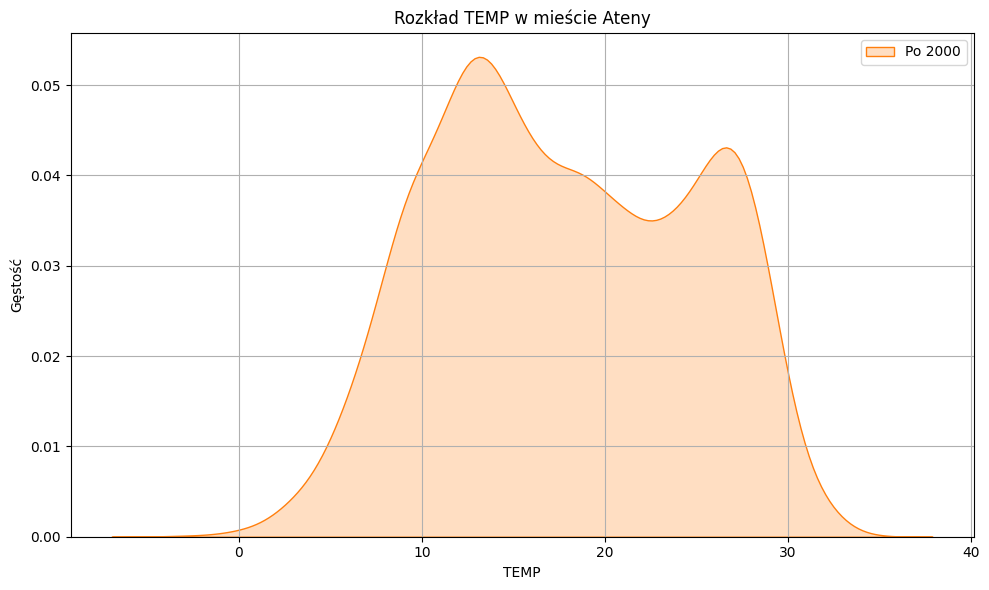

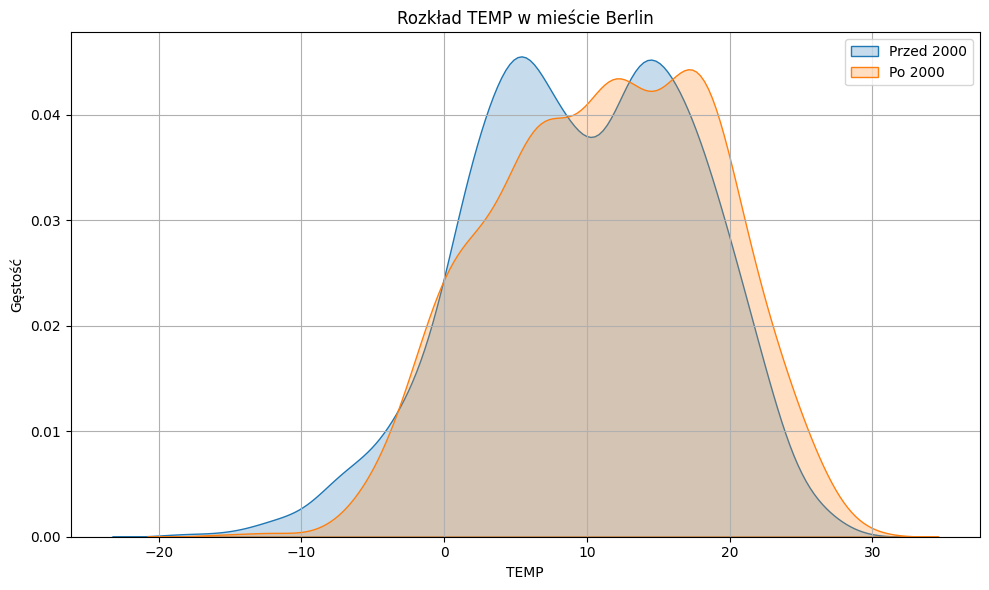

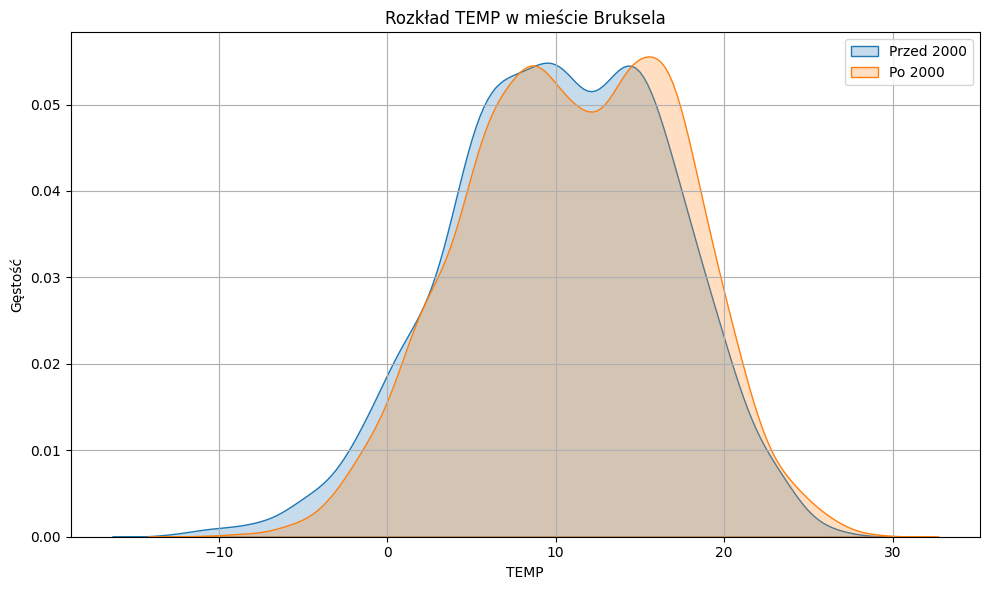

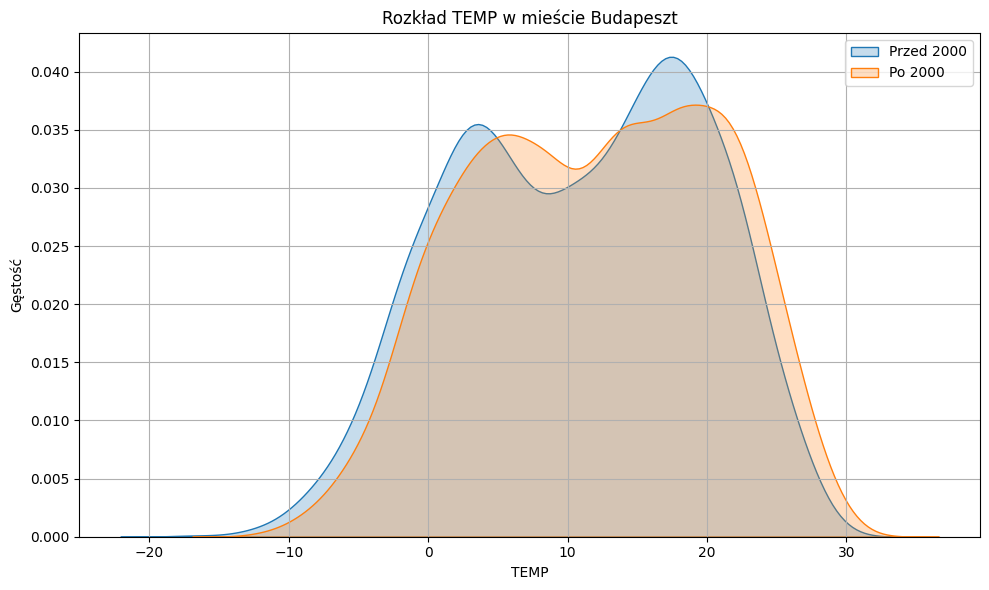

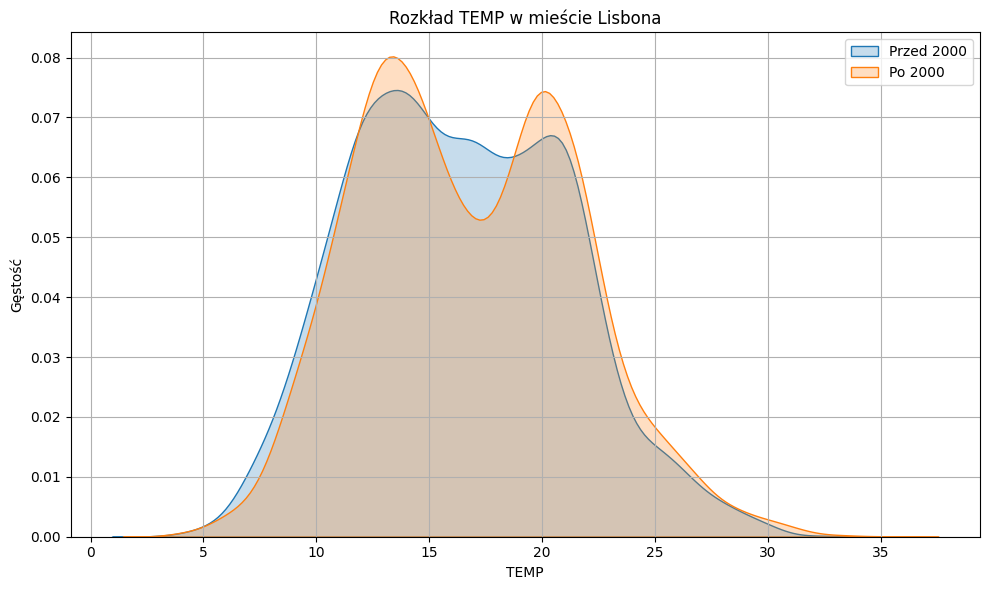

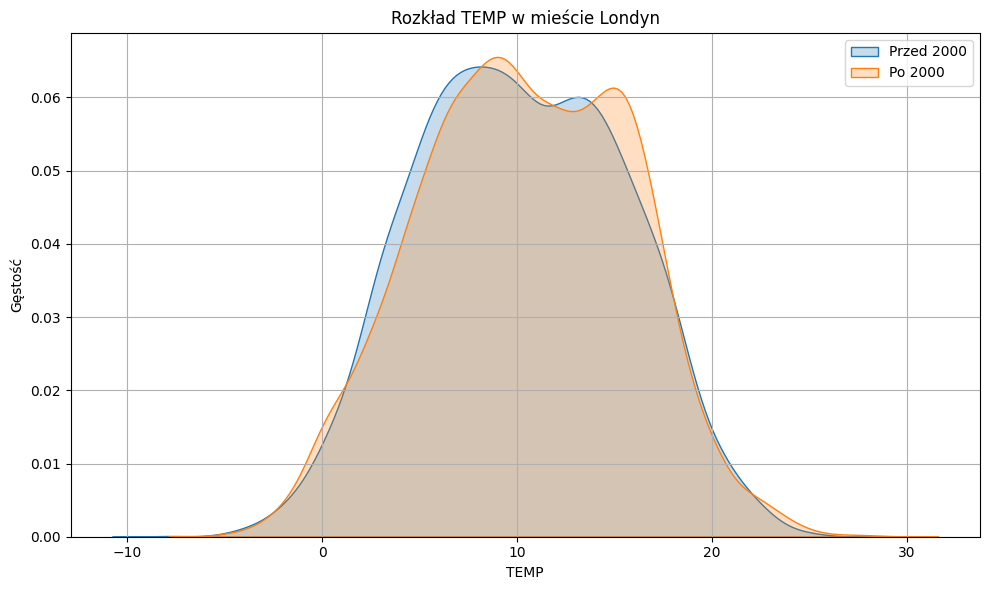

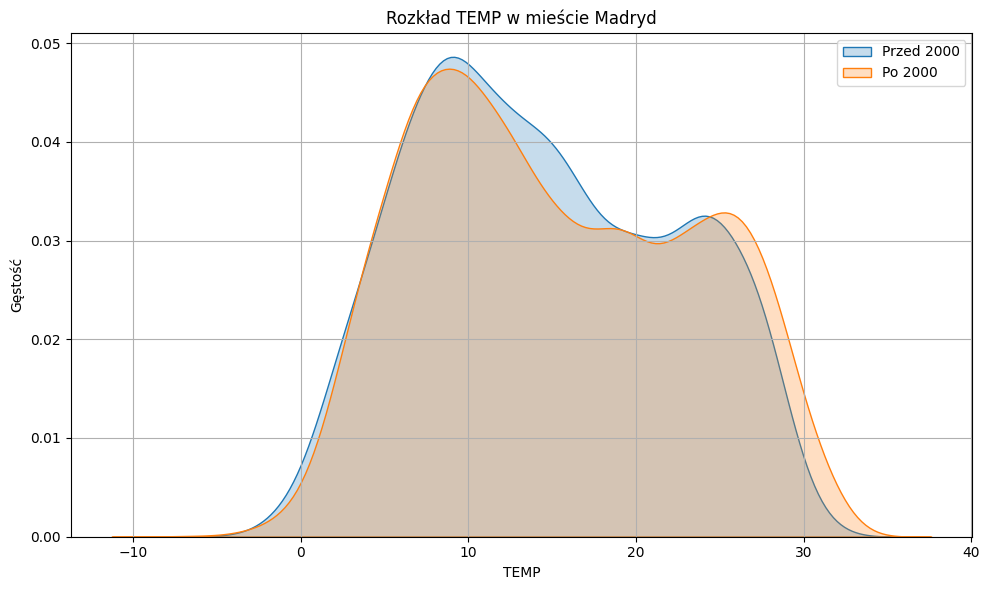

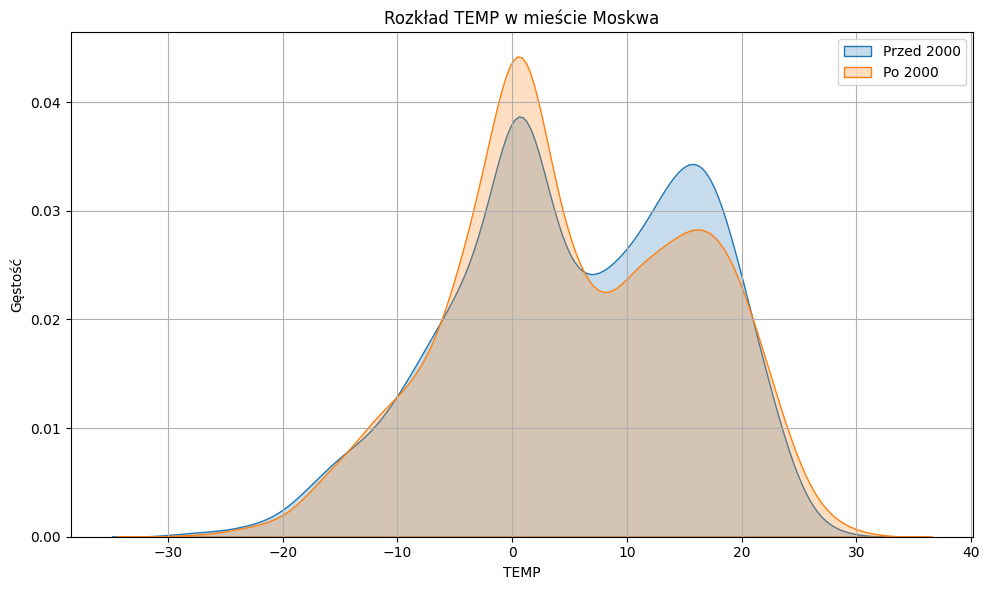

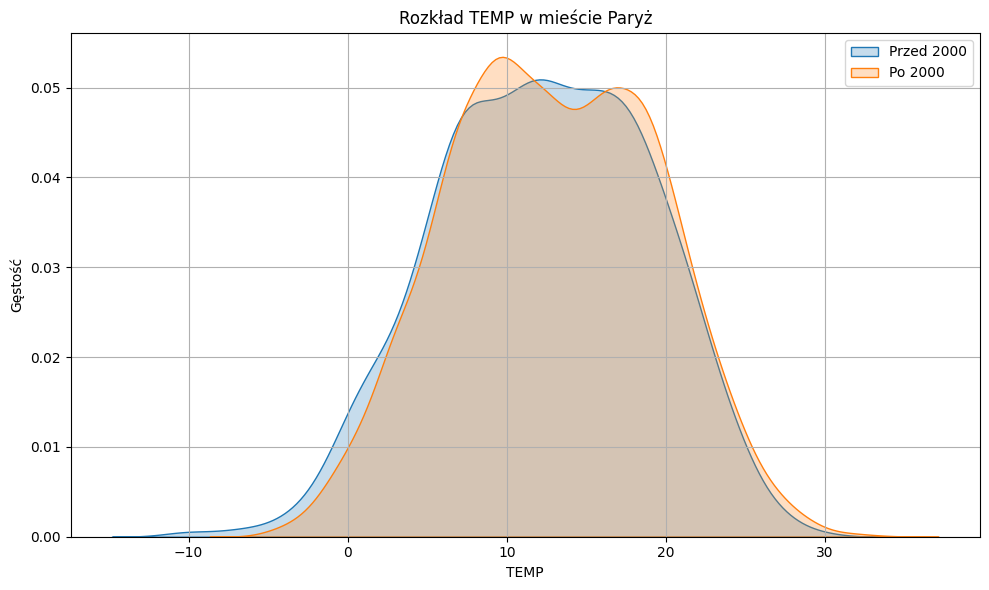

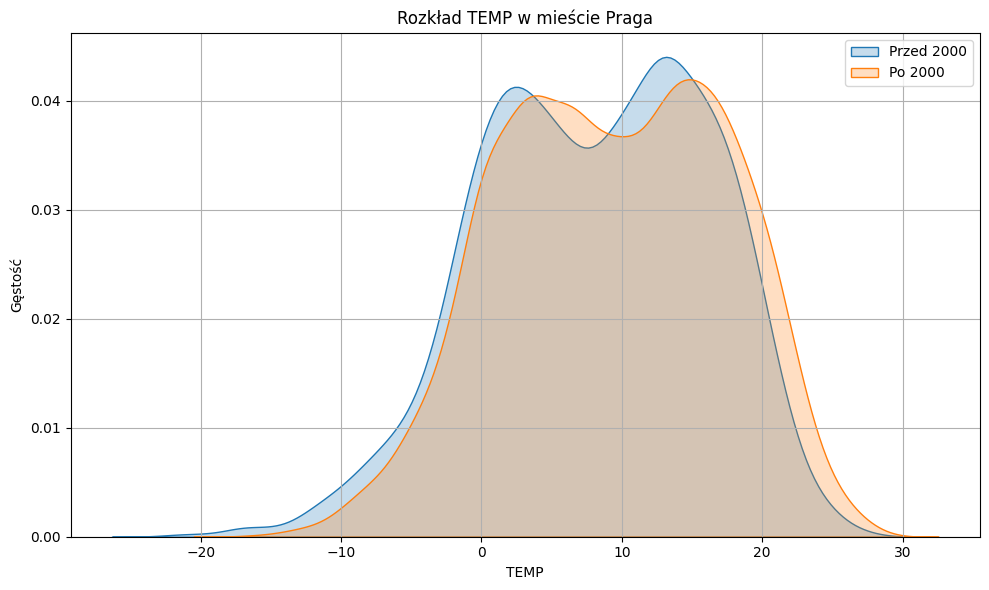

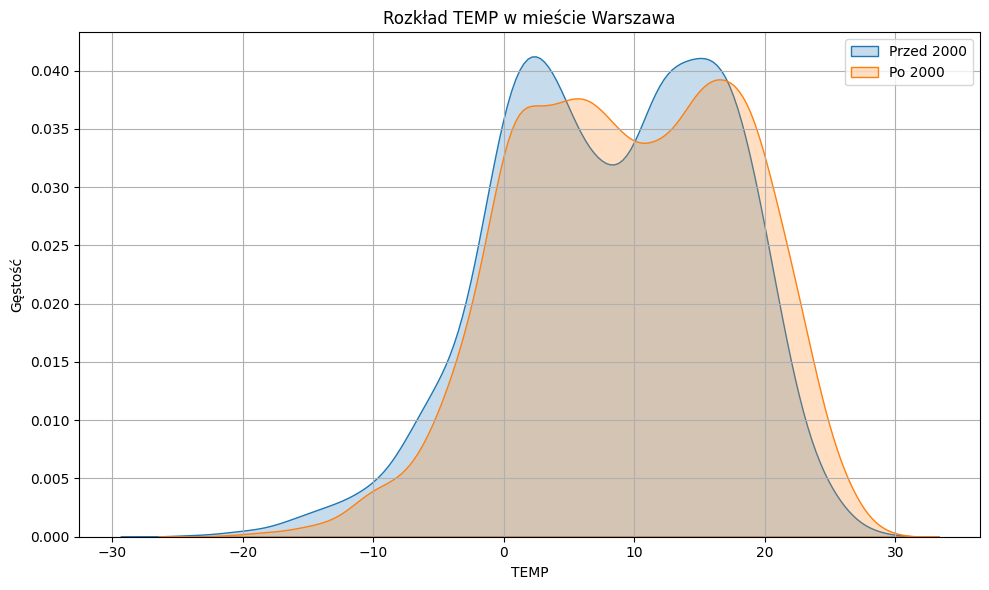

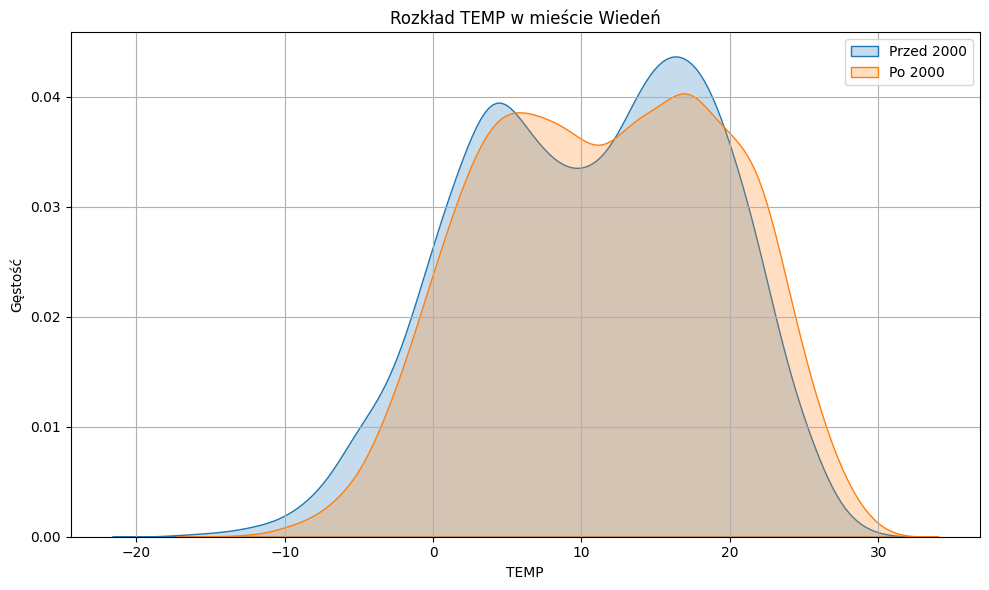

In [9]:
compare_distributions(cities, city_list)

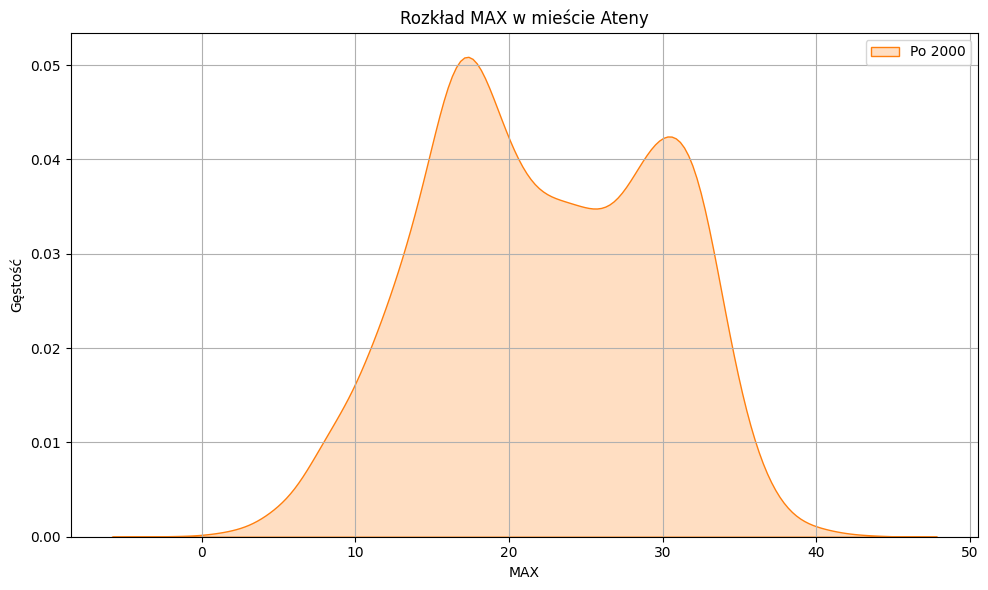

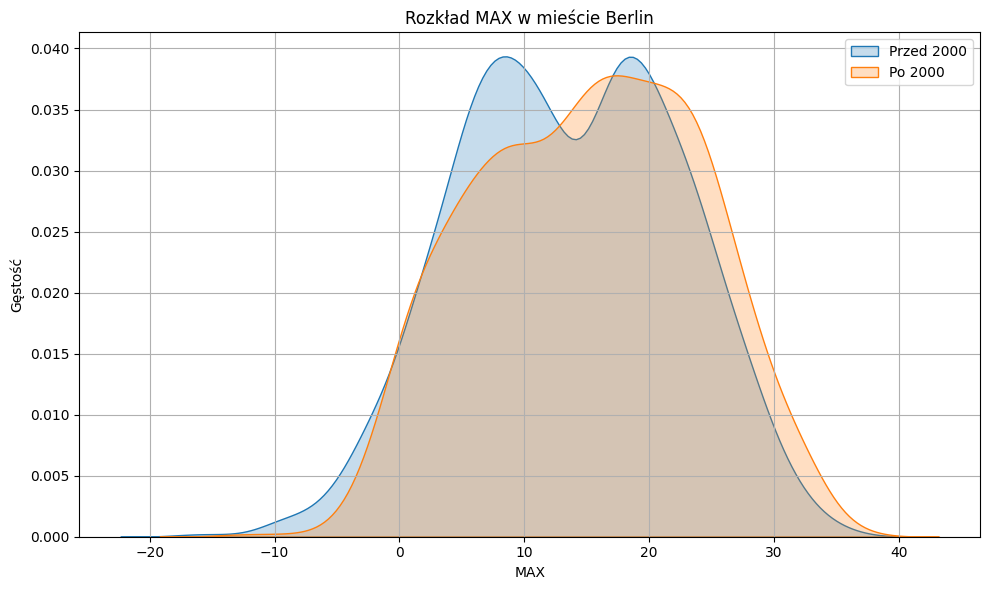

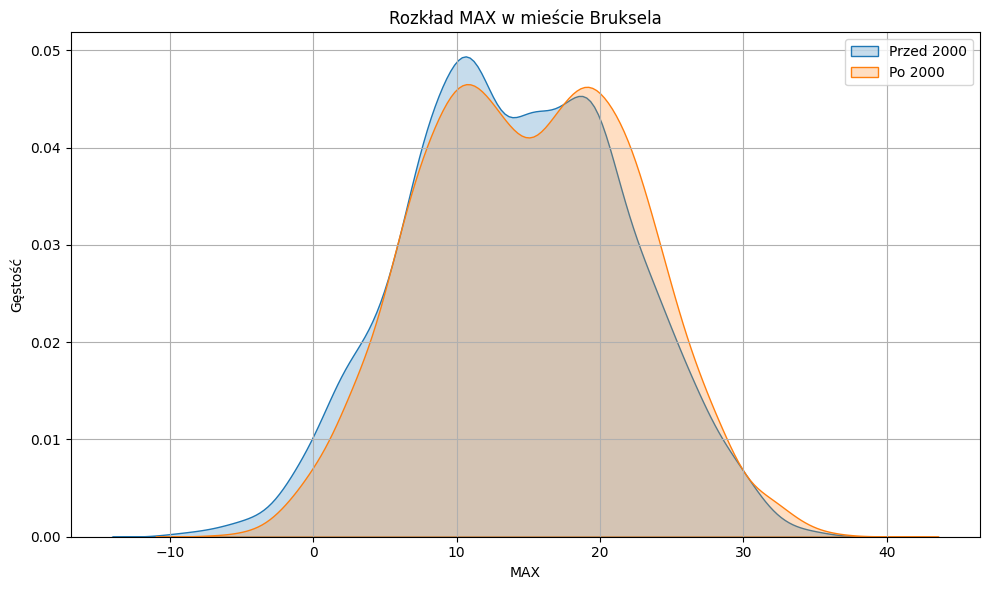

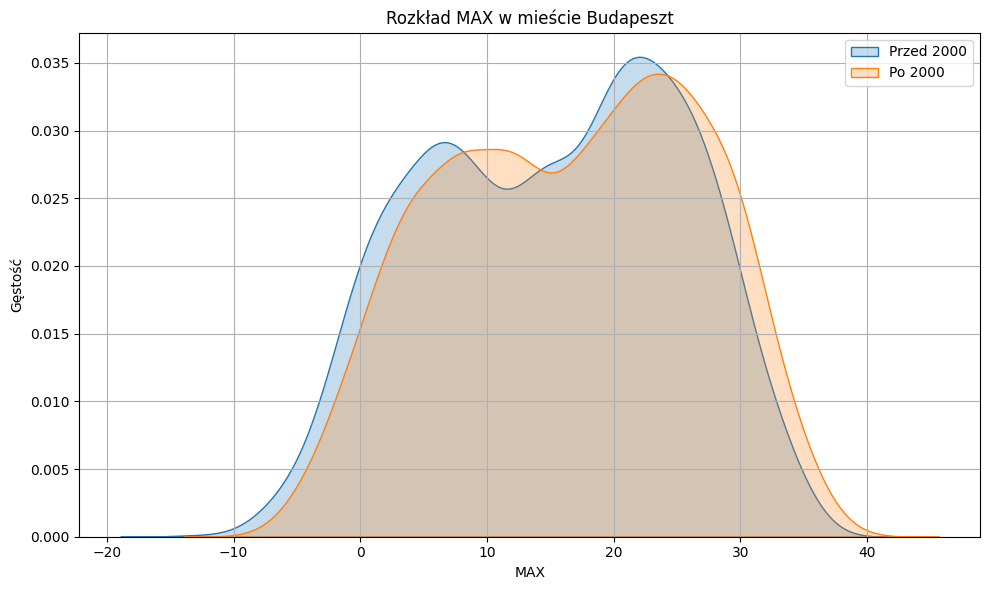

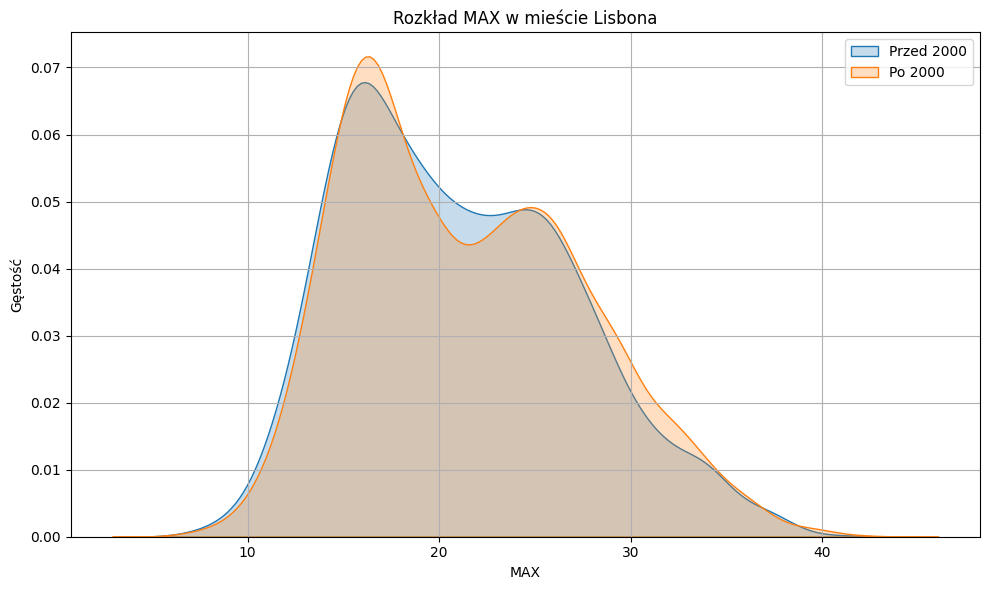

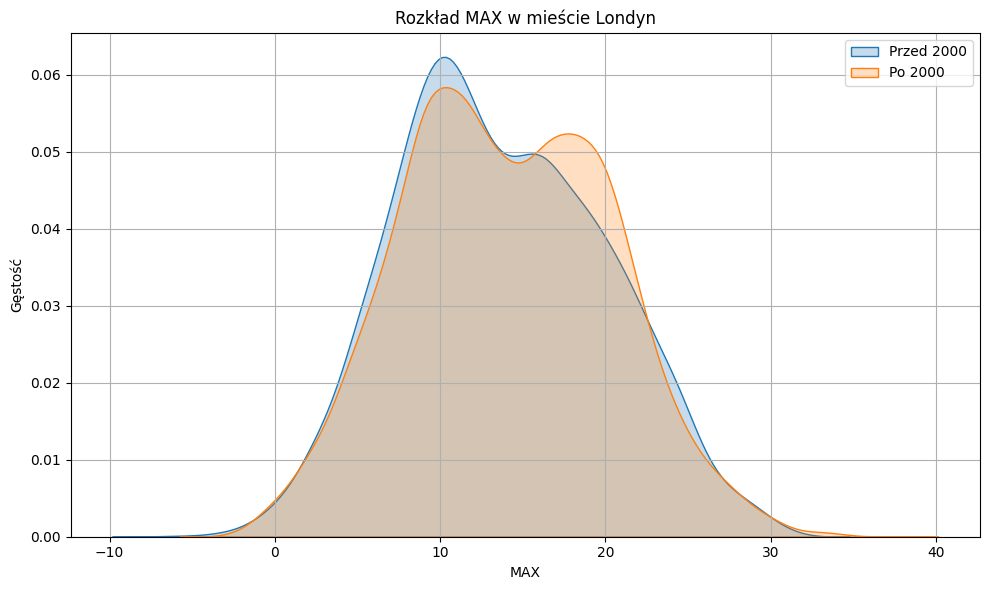

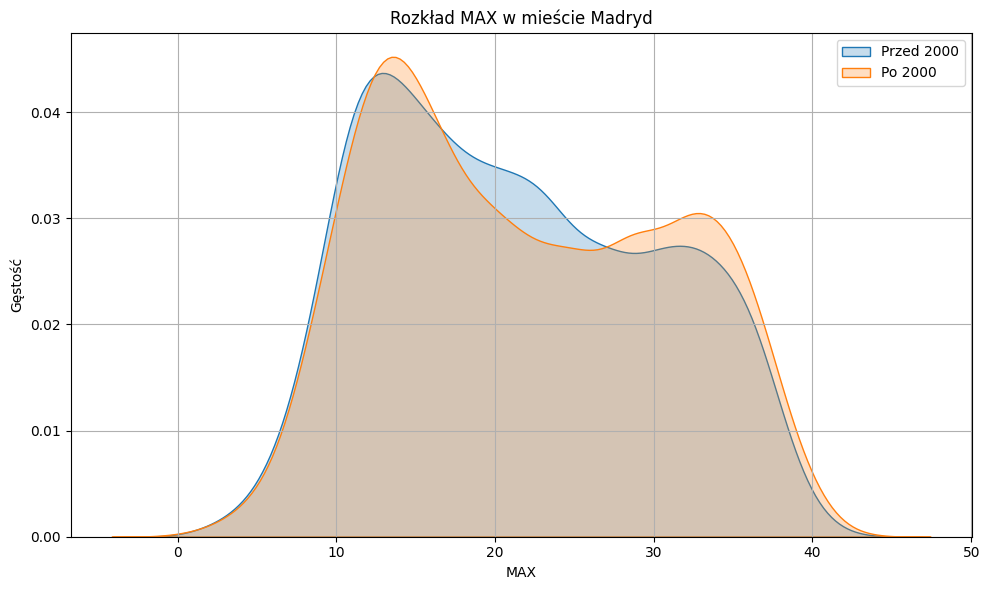

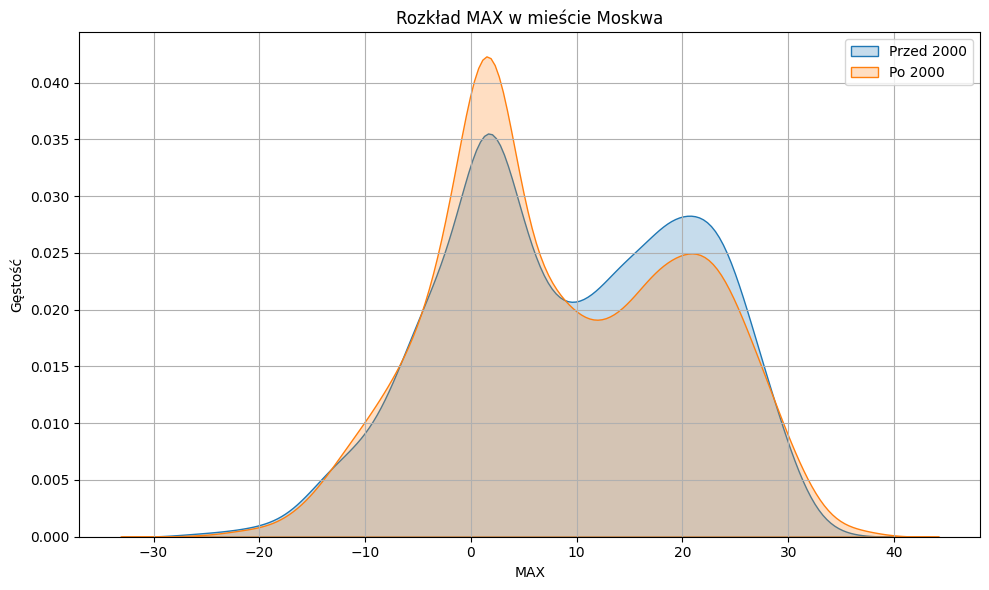

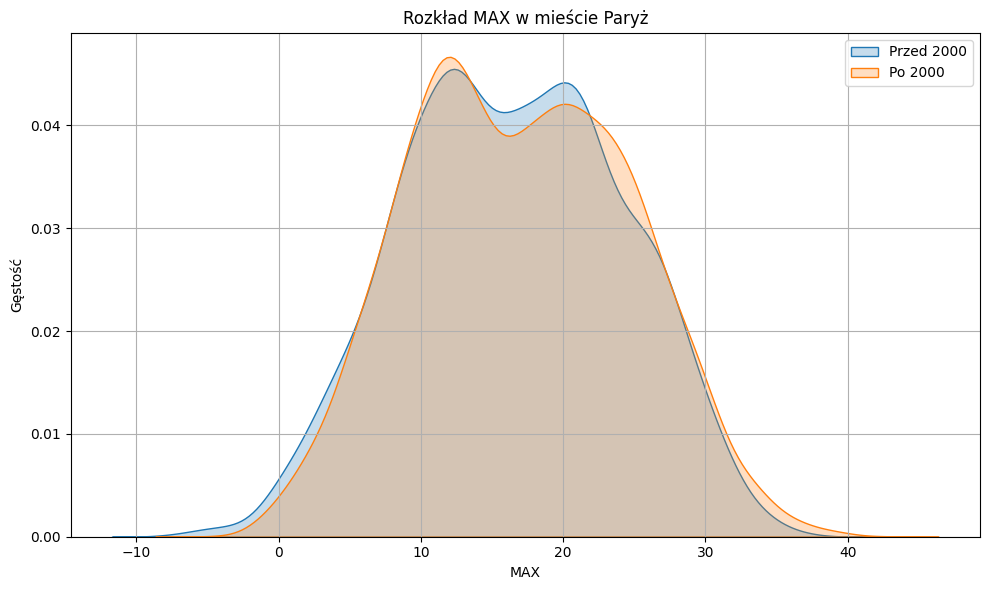

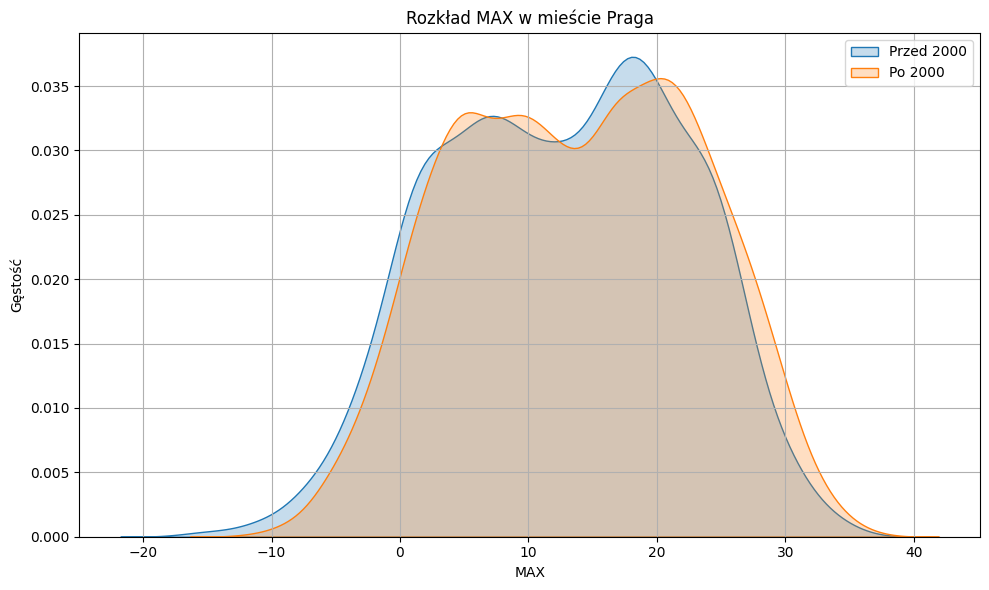

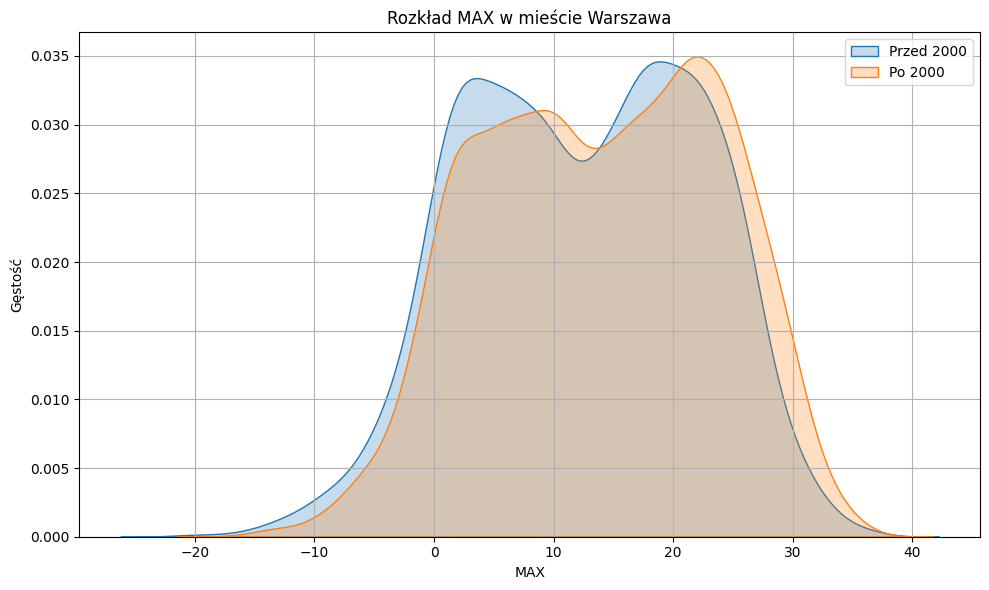

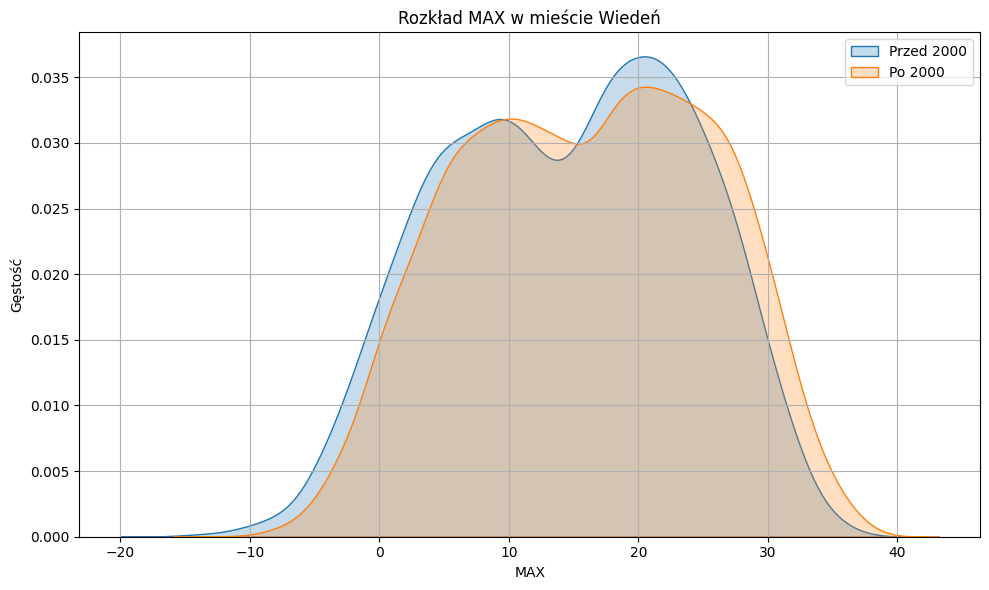

In [10]:
compare_distributions(cities, city_list, col="MAX")

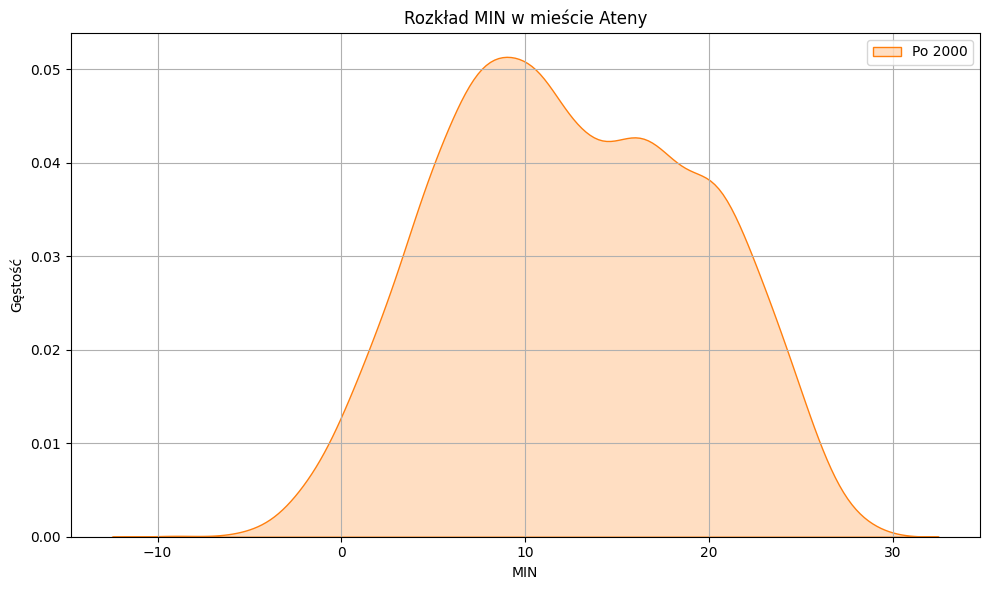

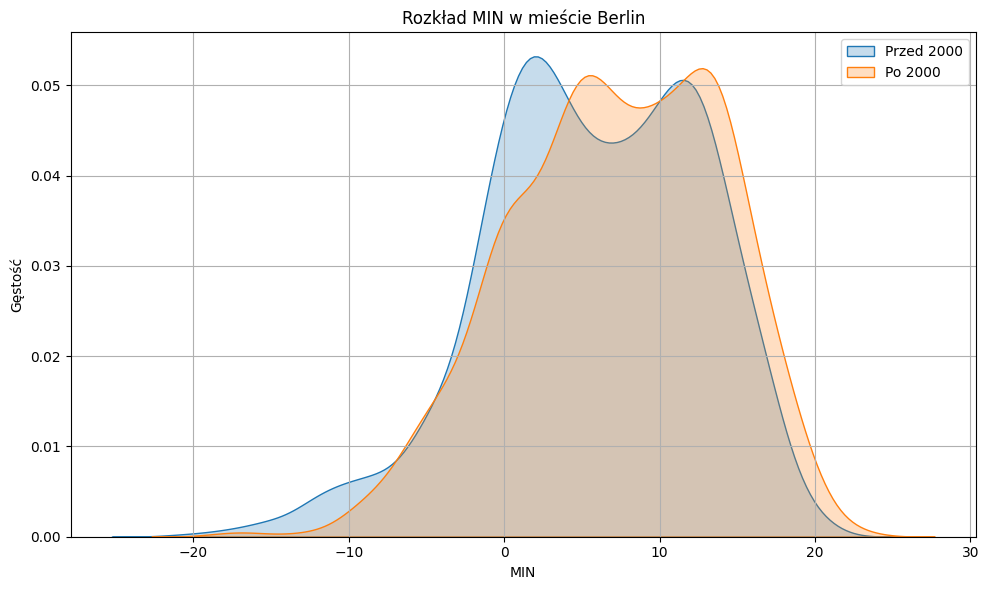

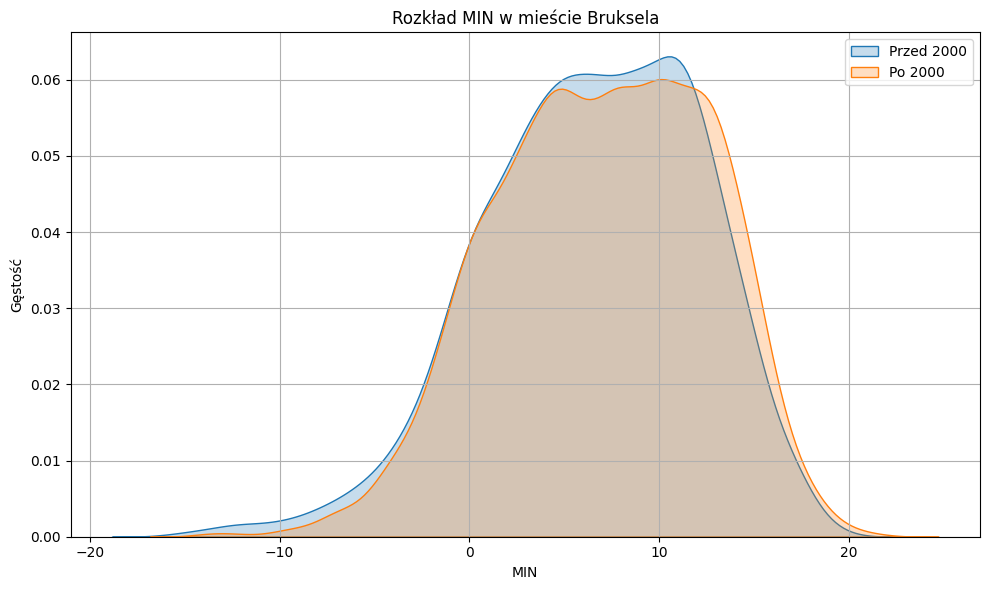

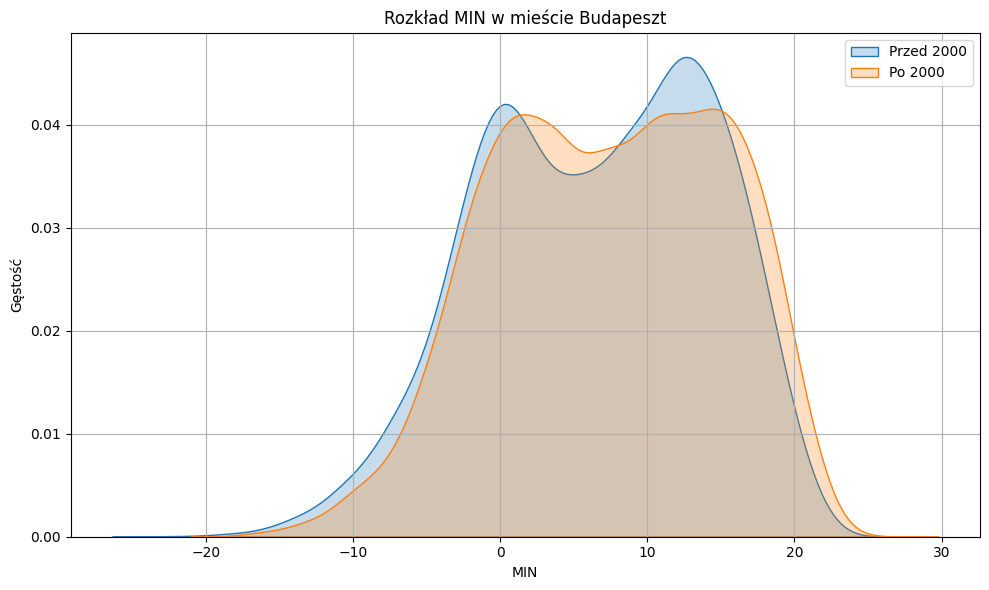

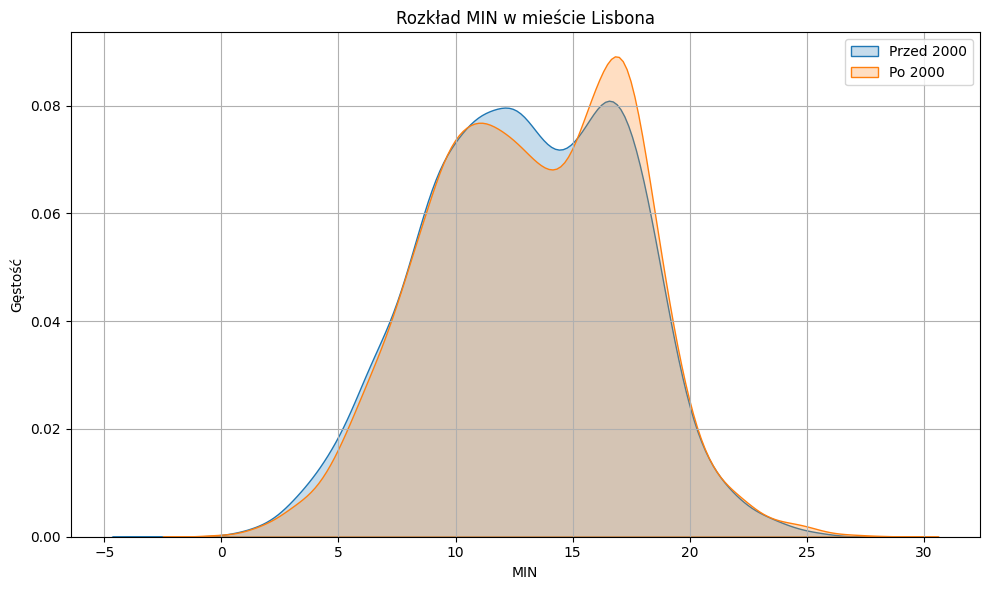

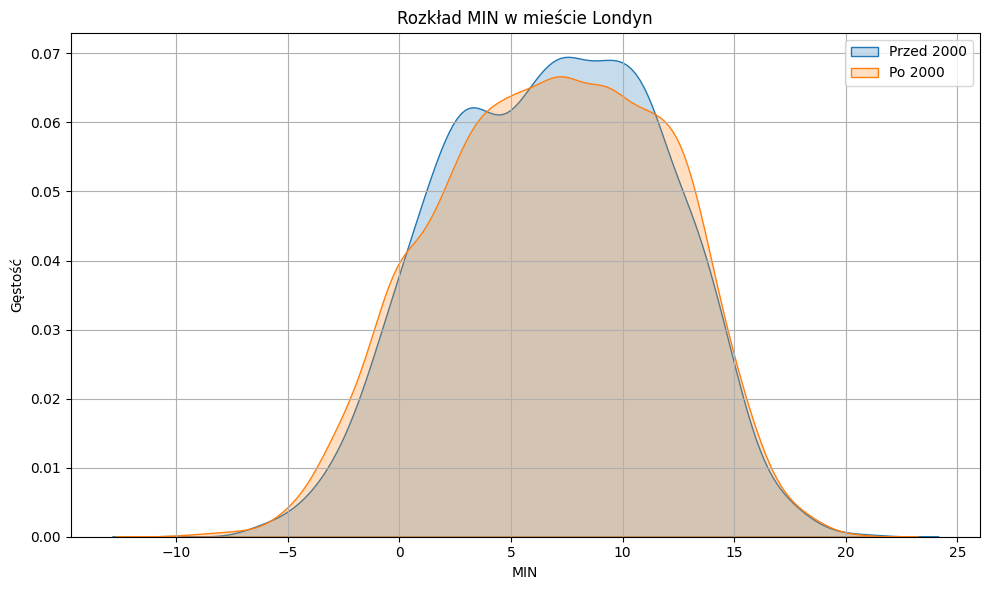

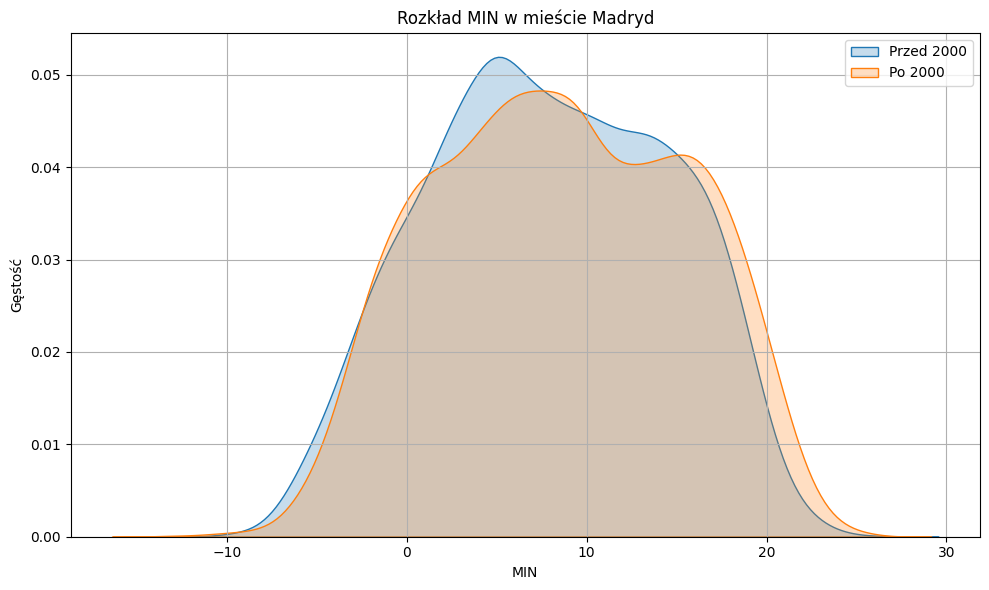

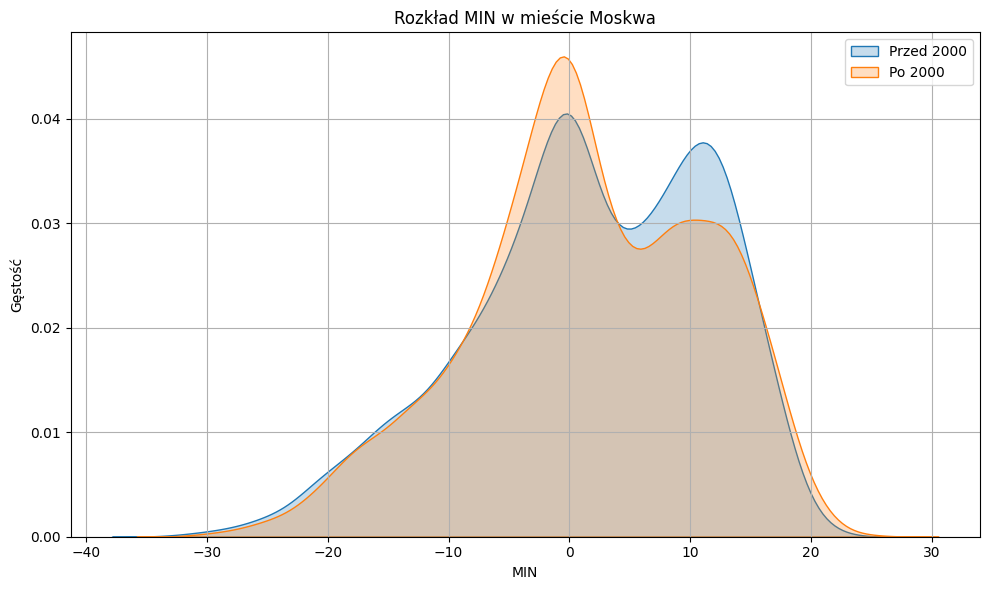

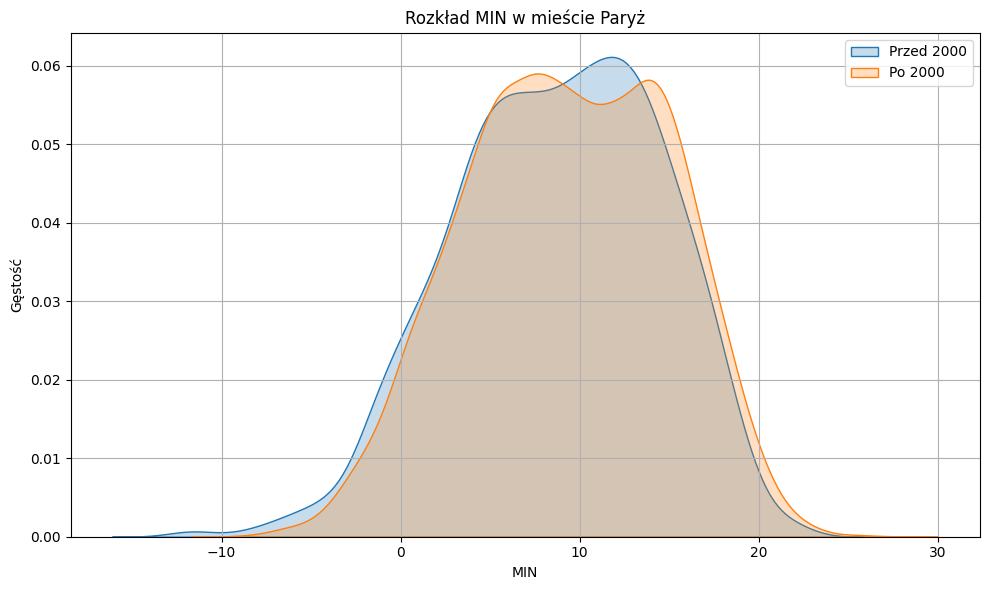

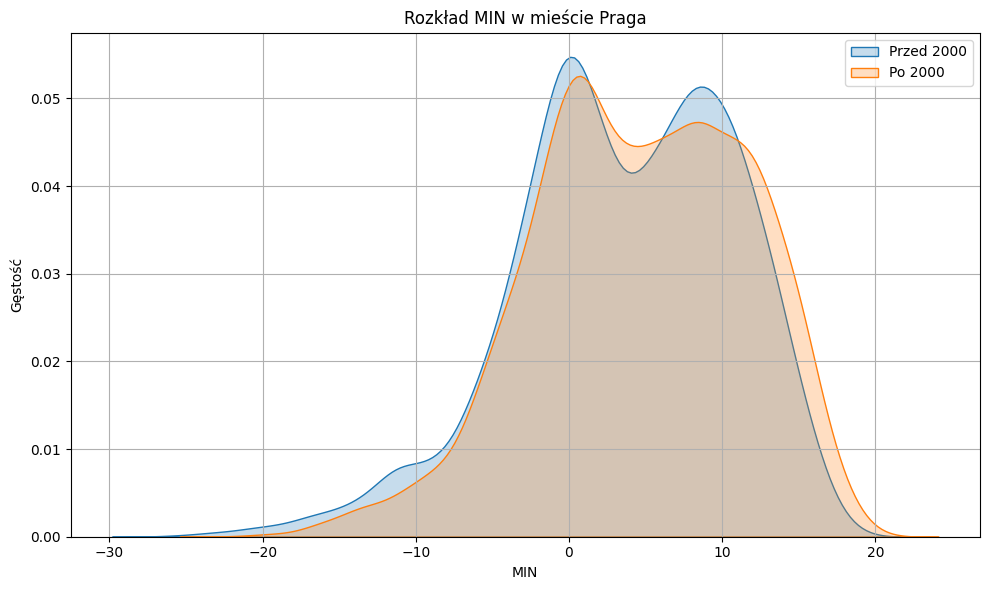

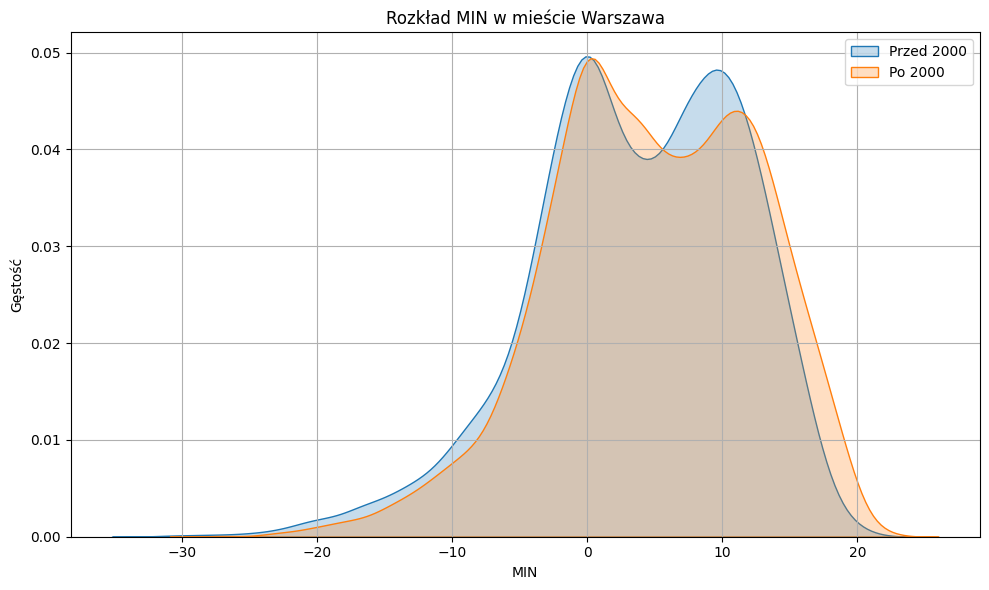

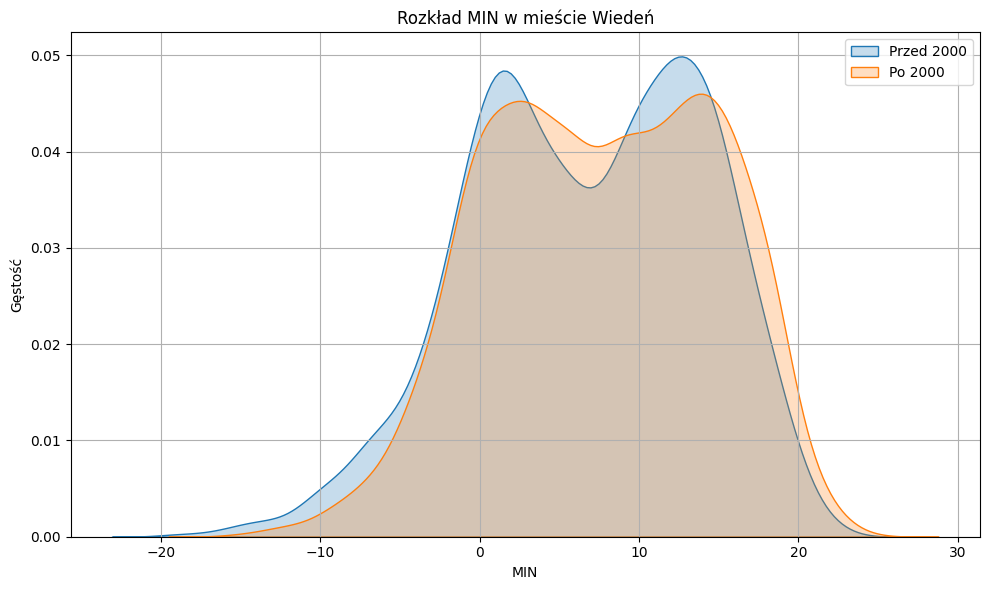

In [11]:
compare_distributions(cities, city_list, col="MIN")

In [12]:
results_temp = statistical_analysis(cities, city_list)

In [13]:
results_temp

Miasto            Test  P-wartość  Średnia przed  Średnia po
0      Berlin  Mann-Whitney U     0.0000           9.66       11.20
1    Bruksela  Mann-Whitney U     0.0000          10.25       11.09
2   Budapeszt  Mann-Whitney U     0.0000          10.78       11.91
3     Lisbona  Mann-Whitney U     0.0001          16.40       16.76
4      Londyn  Mann-Whitney U     0.0049          10.13       10.40
5      Madryd  Mann-Whitney U     0.0001          14.49       15.14
6      Moskwa  Mann-Whitney U     0.0220           5.57        5.23
7       Paryż  Mann-Whitney U     0.0011          12.26       12.85
8       Praga  Mann-Whitney U     0.0000           8.06        9.32
9    Warszawa  Mann-Whitney U     0.0000           8.18        9.46
10     Wiedeń  Mann-Whitney U     0.0000          10.45       11.55

In [14]:
results_min = statistical_analysis(cities, city_list, col="MIN")

In [15]:
results_min

Miasto            Test  P-wartość  Średnia przed  Średnia po
0      Berlin  Mann-Whitney U     0.0000           5.71        7.19
1    Bruksela  Mann-Whitney U     0.0000           6.43        7.00
2   Budapeszt  Mann-Whitney U     0.0000           6.47        7.30
3     Lisbona  Mann-Whitney U     0.0053          13.04       13.26
4      Londyn  Mann-Whitney U     0.9129           6.85        6.83
5      Madryd  Mann-Whitney U     0.0000           7.88        8.51
6      Moskwa  Mann-Whitney U     0.0575           1.65        1.47
7       Paryż  Mann-Whitney U     0.0002           8.74        9.31
8       Praga  Mann-Whitney U     0.0000           3.56        4.62
9    Warszawa  Mann-Whitney U     0.0000           3.69        4.78
10     Wiedeń  Mann-Whitney U     0.0000           6.69        7.62

In [16]:
results_max = statistical_analysis(cities, city_list, col="MAX")

In [17]:
results_max

Miasto            Test  P-wartość  Średnia przed  Średnia po
0      Berlin  Mann-Whitney U     0.0000          13.51       15.10
1    Bruksela  Mann-Whitney U     0.0000          14.16       15.07
2   Budapeszt  Mann-Whitney U     0.0000          15.18       16.61
3     Lisbona  Mann-Whitney U     0.0045          21.06       21.39
4      Londyn  Mann-Whitney U     0.0021          13.69       14.03
5      Madryd  Mann-Whitney U     0.0014          21.24       21.78
6      Moskwa  Mann-Whitney U     0.0008           9.24        8.60
7       Paryż  Mann-Whitney U     0.0145          16.44       16.98
8       Praga  Mann-Whitney U     0.0000          12.66       13.75
9    Warszawa  Mann-Whitney U     0.0000          12.36       13.91
10     Wiedeń  Mann-Whitney U     0.0000          14.52       15.97

In [18]:
def analyze_phenomena_cities(cities, city_list, phenomena, split_year):
    results = {}

    for city in city_list:
        df = cities[city].copy()
        if 'Year' not in df.columns:
            df['Year'] = pd.to_datetime(df['DATE']).dt.year
        
        city_results = {}

        plt.figure(figsize=(16, 4*len(phenomena)))
        plt.suptitle(f'Analiza zjawisk w mieście: {city}', fontsize=16)

        for i, pheno in enumerate(phenomena, 1):
            data = df[[pheno, 'Year']].dropna()

            before = data[data['Year'] < split_year][pheno]
            after = data[data['Year'] >= split_year][pheno]

            plt.subplot(len(phenomena), 1, i)

            # Rysuj KDE tylko jeśli wariancja > 0
            if before.var() > 0:
                sns.kdeplot(before, label=f'Przed {split_year}', fill=True)
            if after.var() > 0:
                sns.kdeplot(after, label=f'Po {split_year}', fill=True)

            plt.title(f'{pheno} w {city}')
            plt.xlabel('Liczba dni zjawiska')
            plt.ylabel('Gęstość')
            
            # Rysuj legendę tylko jeśli są jakieś linie z etykietami
            handles, labels = plt.gca().get_legend_handles_labels()
            if handles:
                plt.legend()

            def safe_shapiro(series):
                if len(series) < 3 or len(series) > 5000 or series.var() == 0:
                    return np.nan
                try:
                    return shapiro(series).pvalue
                except:
                    return np.nan

            p_b = safe_shapiro(before)
            p_a = safe_shapiro(after)

            # Test równości wariancji Levene
            if len(before) >= 2 and len(after) >= 2:
                stat_lev, p_lev = levene(before, after)
            else:
                p_lev = np.nan

            # Test różnicy rozkładów Mann-Whitney
            if len(before) >= 1 and len(after) >= 1:
                stat_mw, p_mw = mannwhitneyu(before, after, alternative='two-sided')
            else:
                p_mw = np.nan

            std_before = np.std(before, ddof=1) if len(before) > 1 else np.nan
            std_after = np.std(after, ddof=1) if len(after) > 1 else np.nan
            mean_before = np.mean(before) if len(before) > 0 else np.nan
            mean_after = np.mean(after) if len(after) > 0 else np.nan
            cv_before = std_before / mean_before if mean_before not in [0, np.nan] else np.nan
            cv_after = std_after / mean_after if mean_after not in [0, np.nan] else np.nan

            city_results[pheno] = {
                'Shapiro_p_before': p_b,
                'Shapiro_p_after': p_a,
                'Levene_p': p_lev,
                'MannWhitney_p': p_mw,
                'Std_before': std_before,
                'Std_after': std_after,
                'CV_before': cv_before,
                'CV_after': cv_after,
                'Mean_before': mean_before,
                'Mean_after': mean_after,
            }

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        results[city] = city_results

    return results

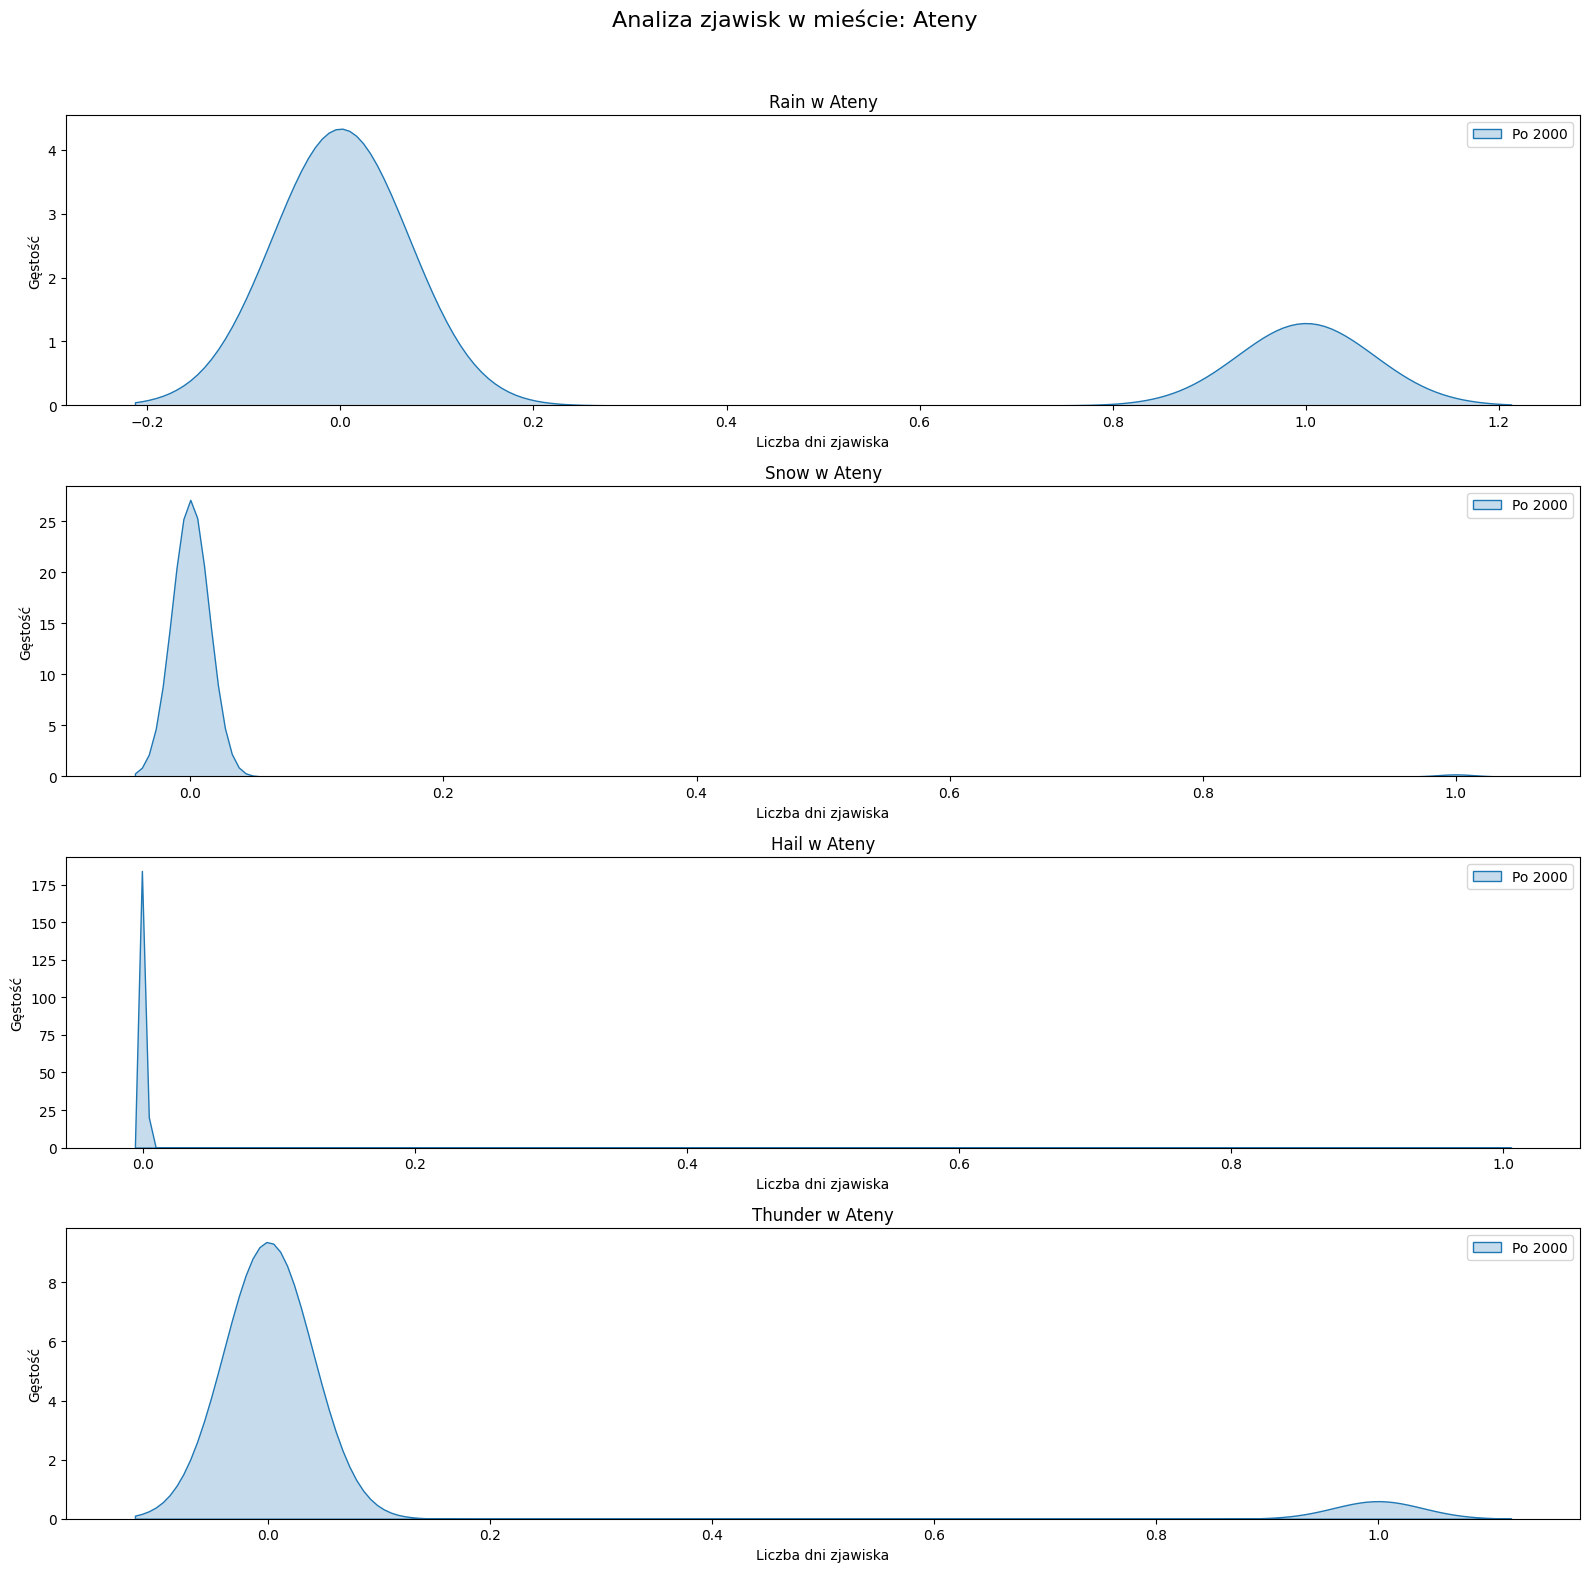

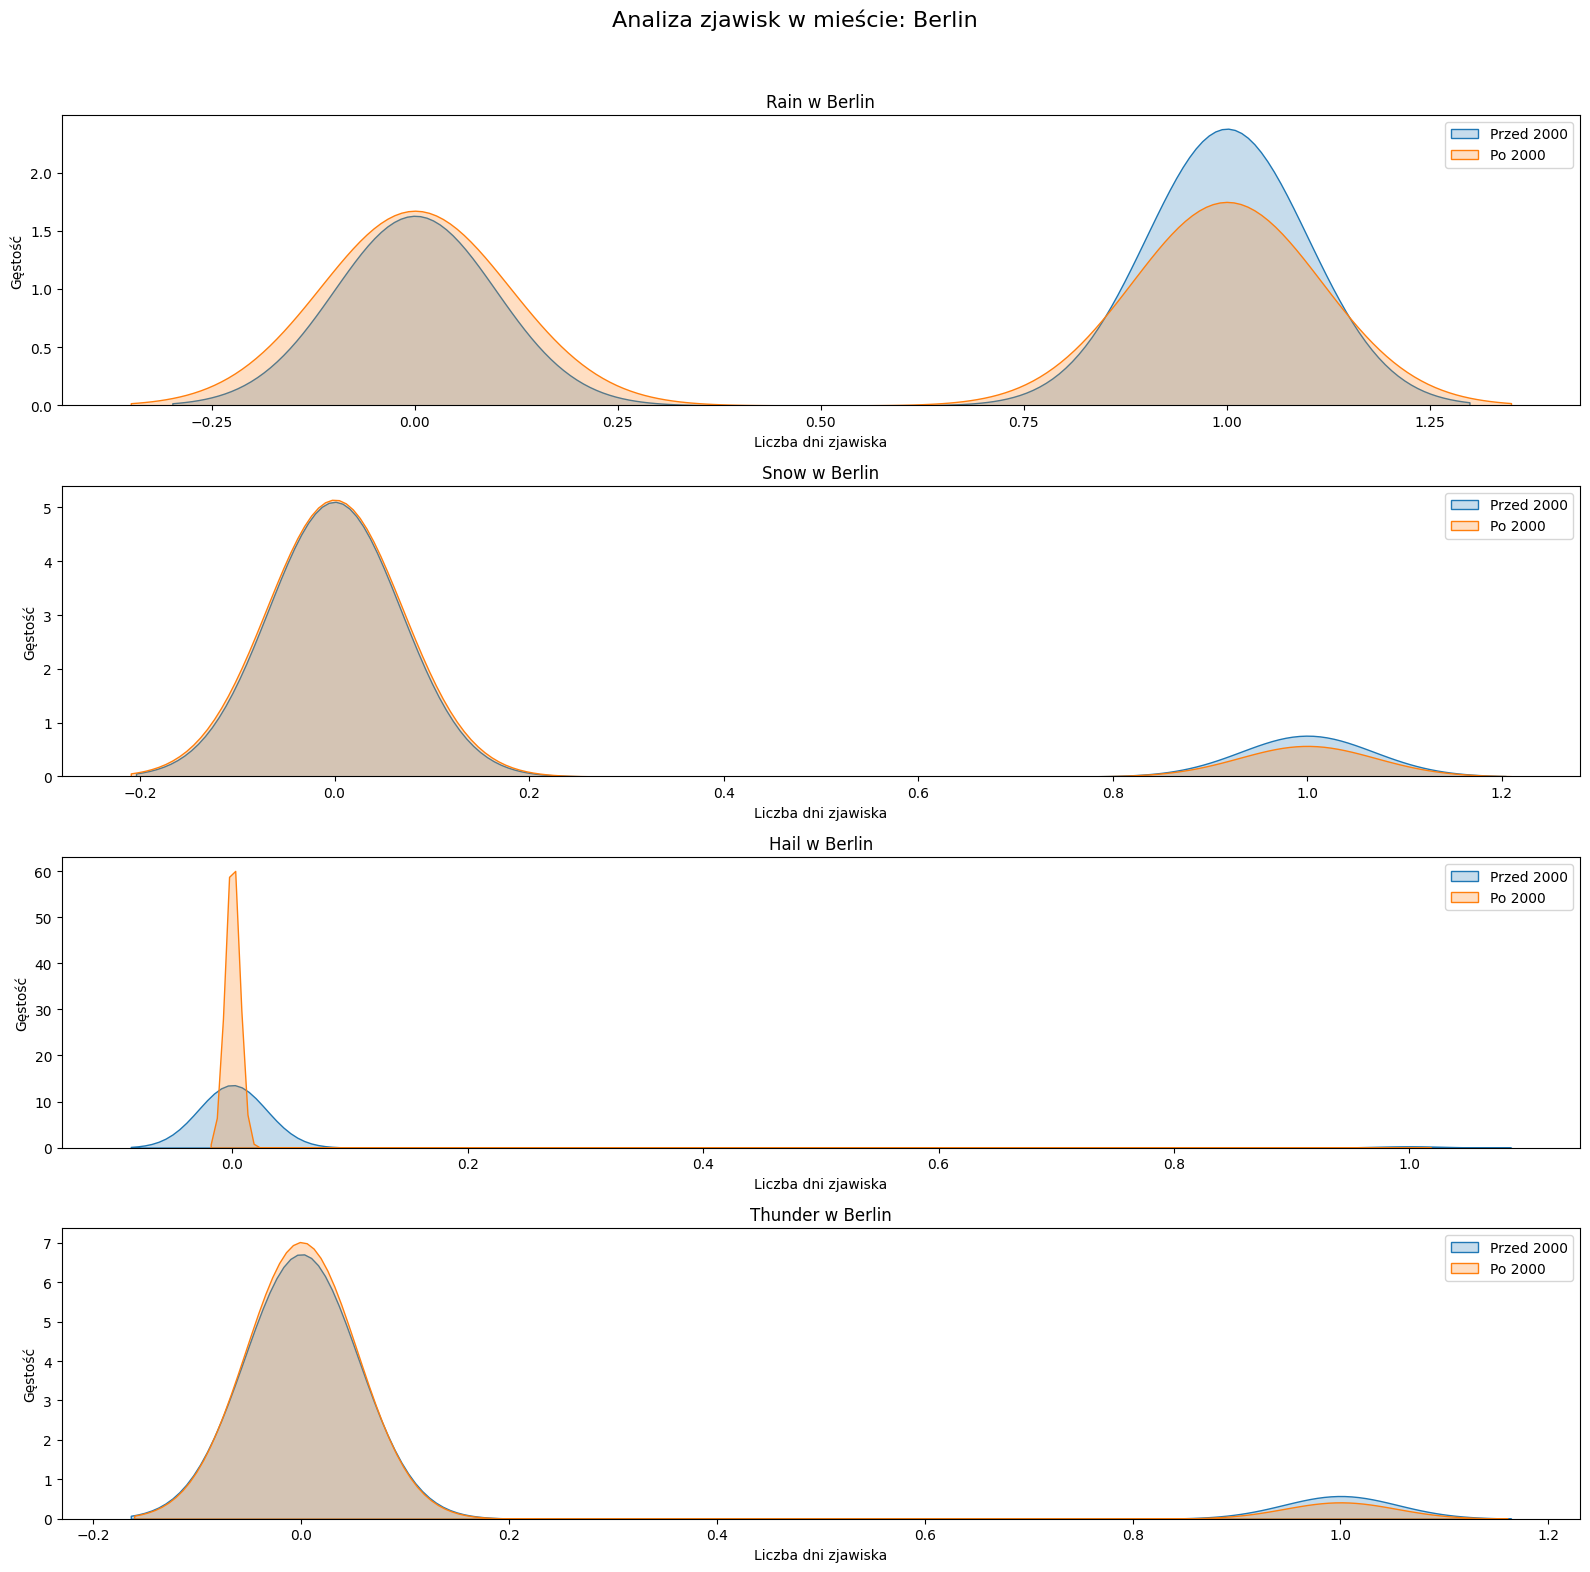

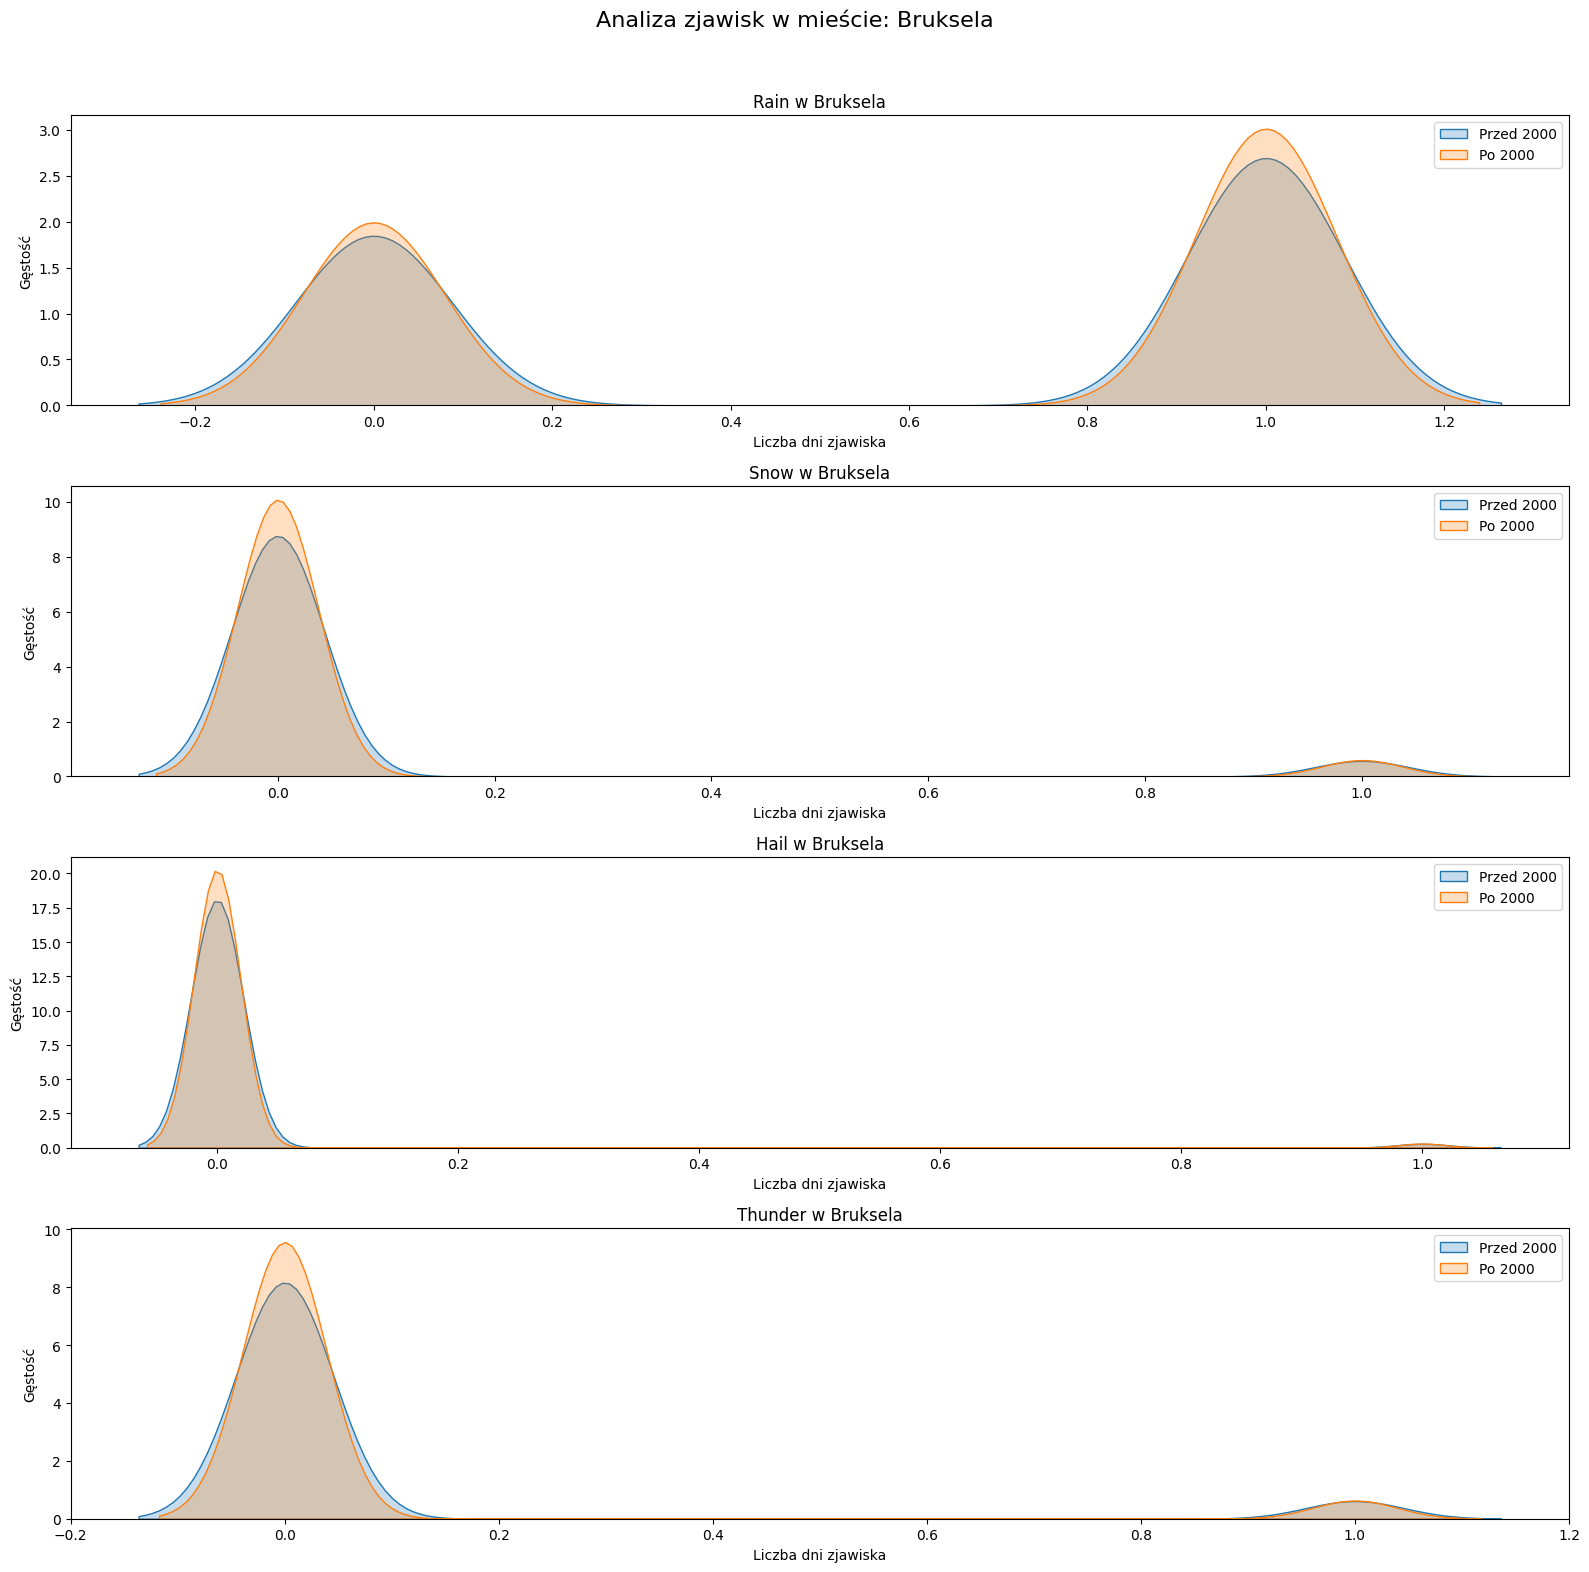

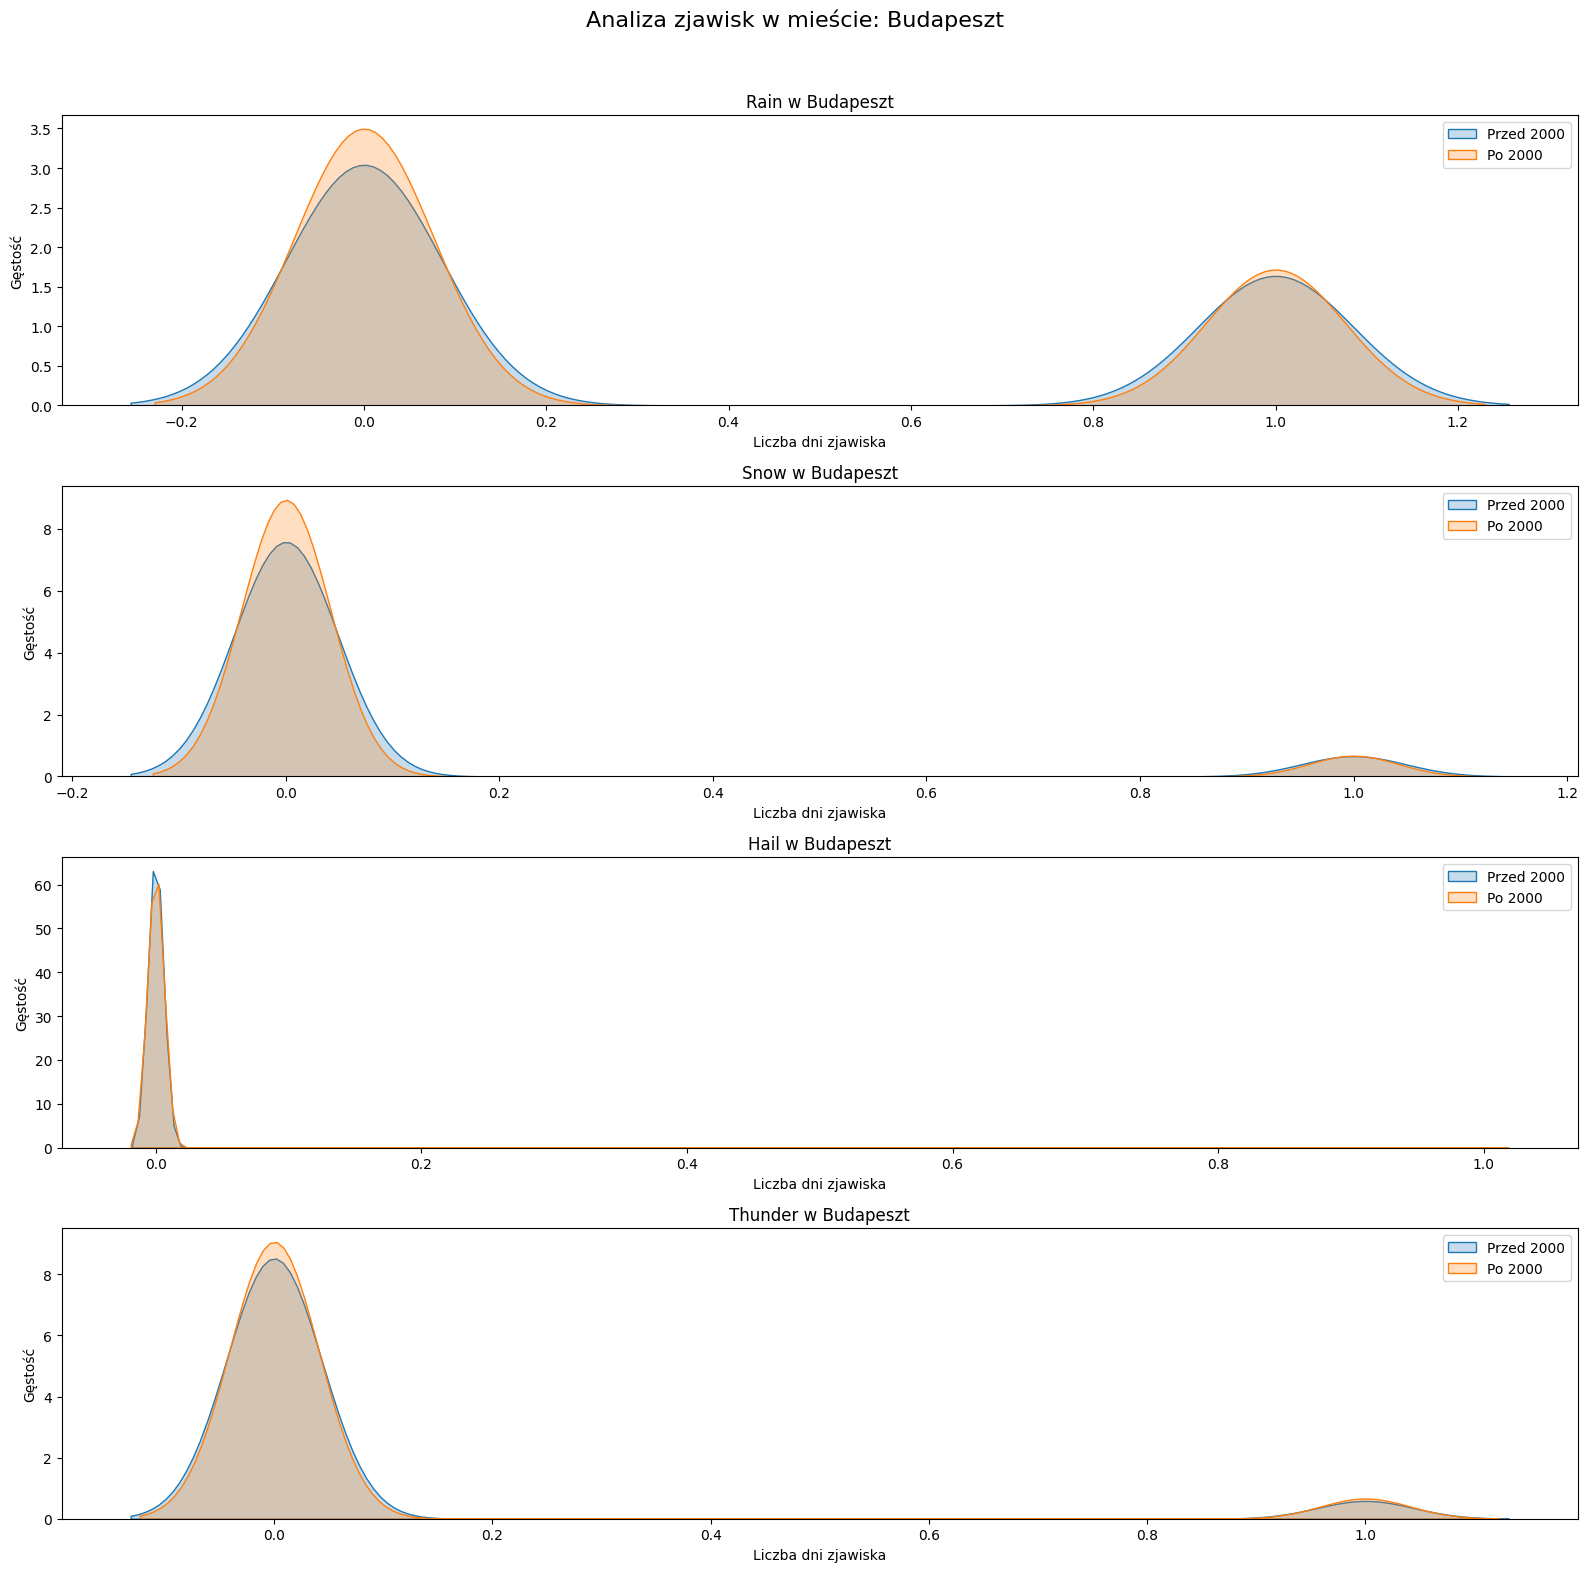

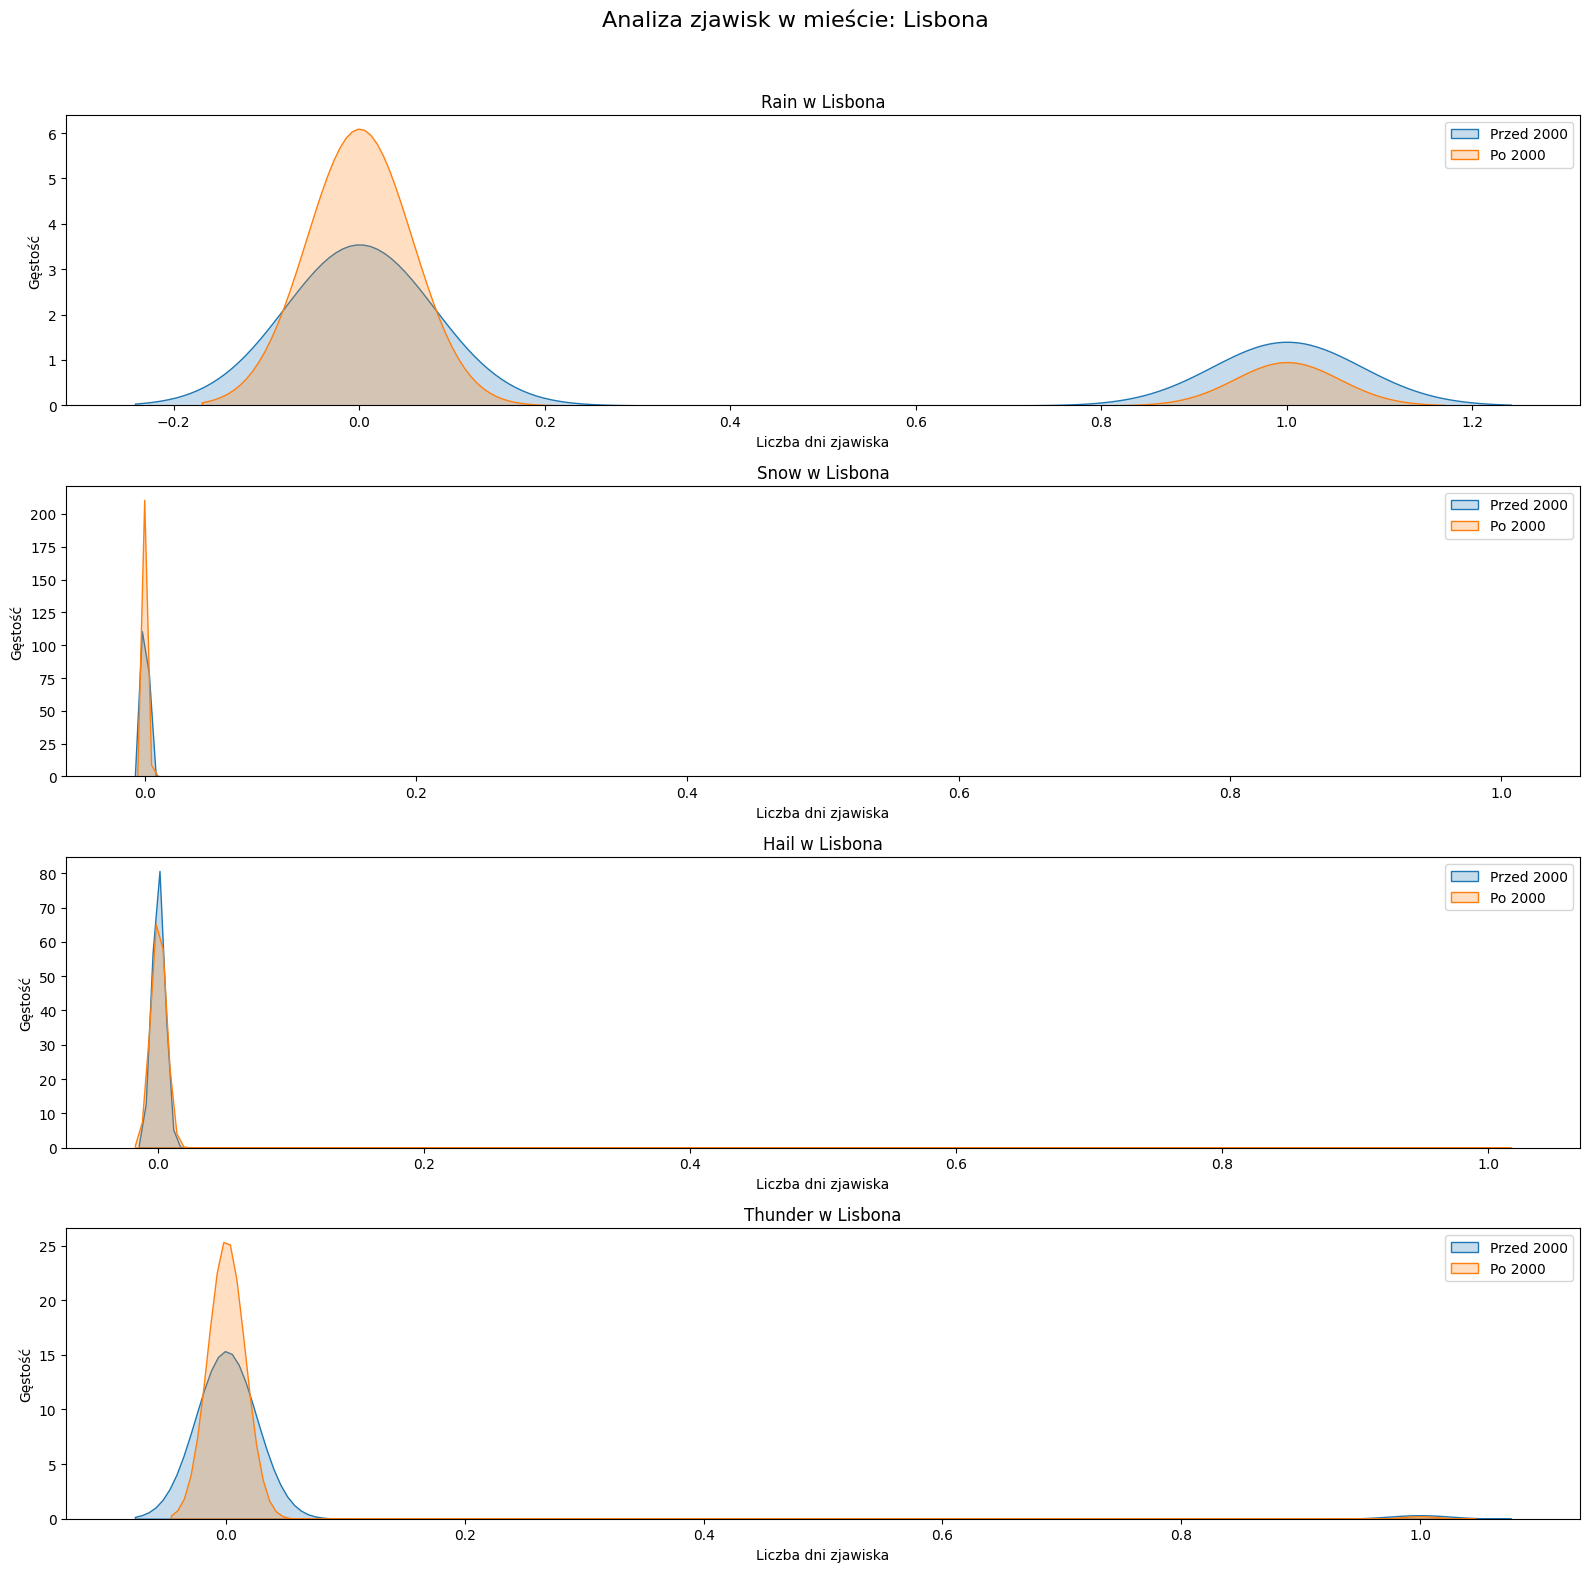

C:\Users\mikos\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_morestats.py:3310: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\mikos\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_morestats.py:3310: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


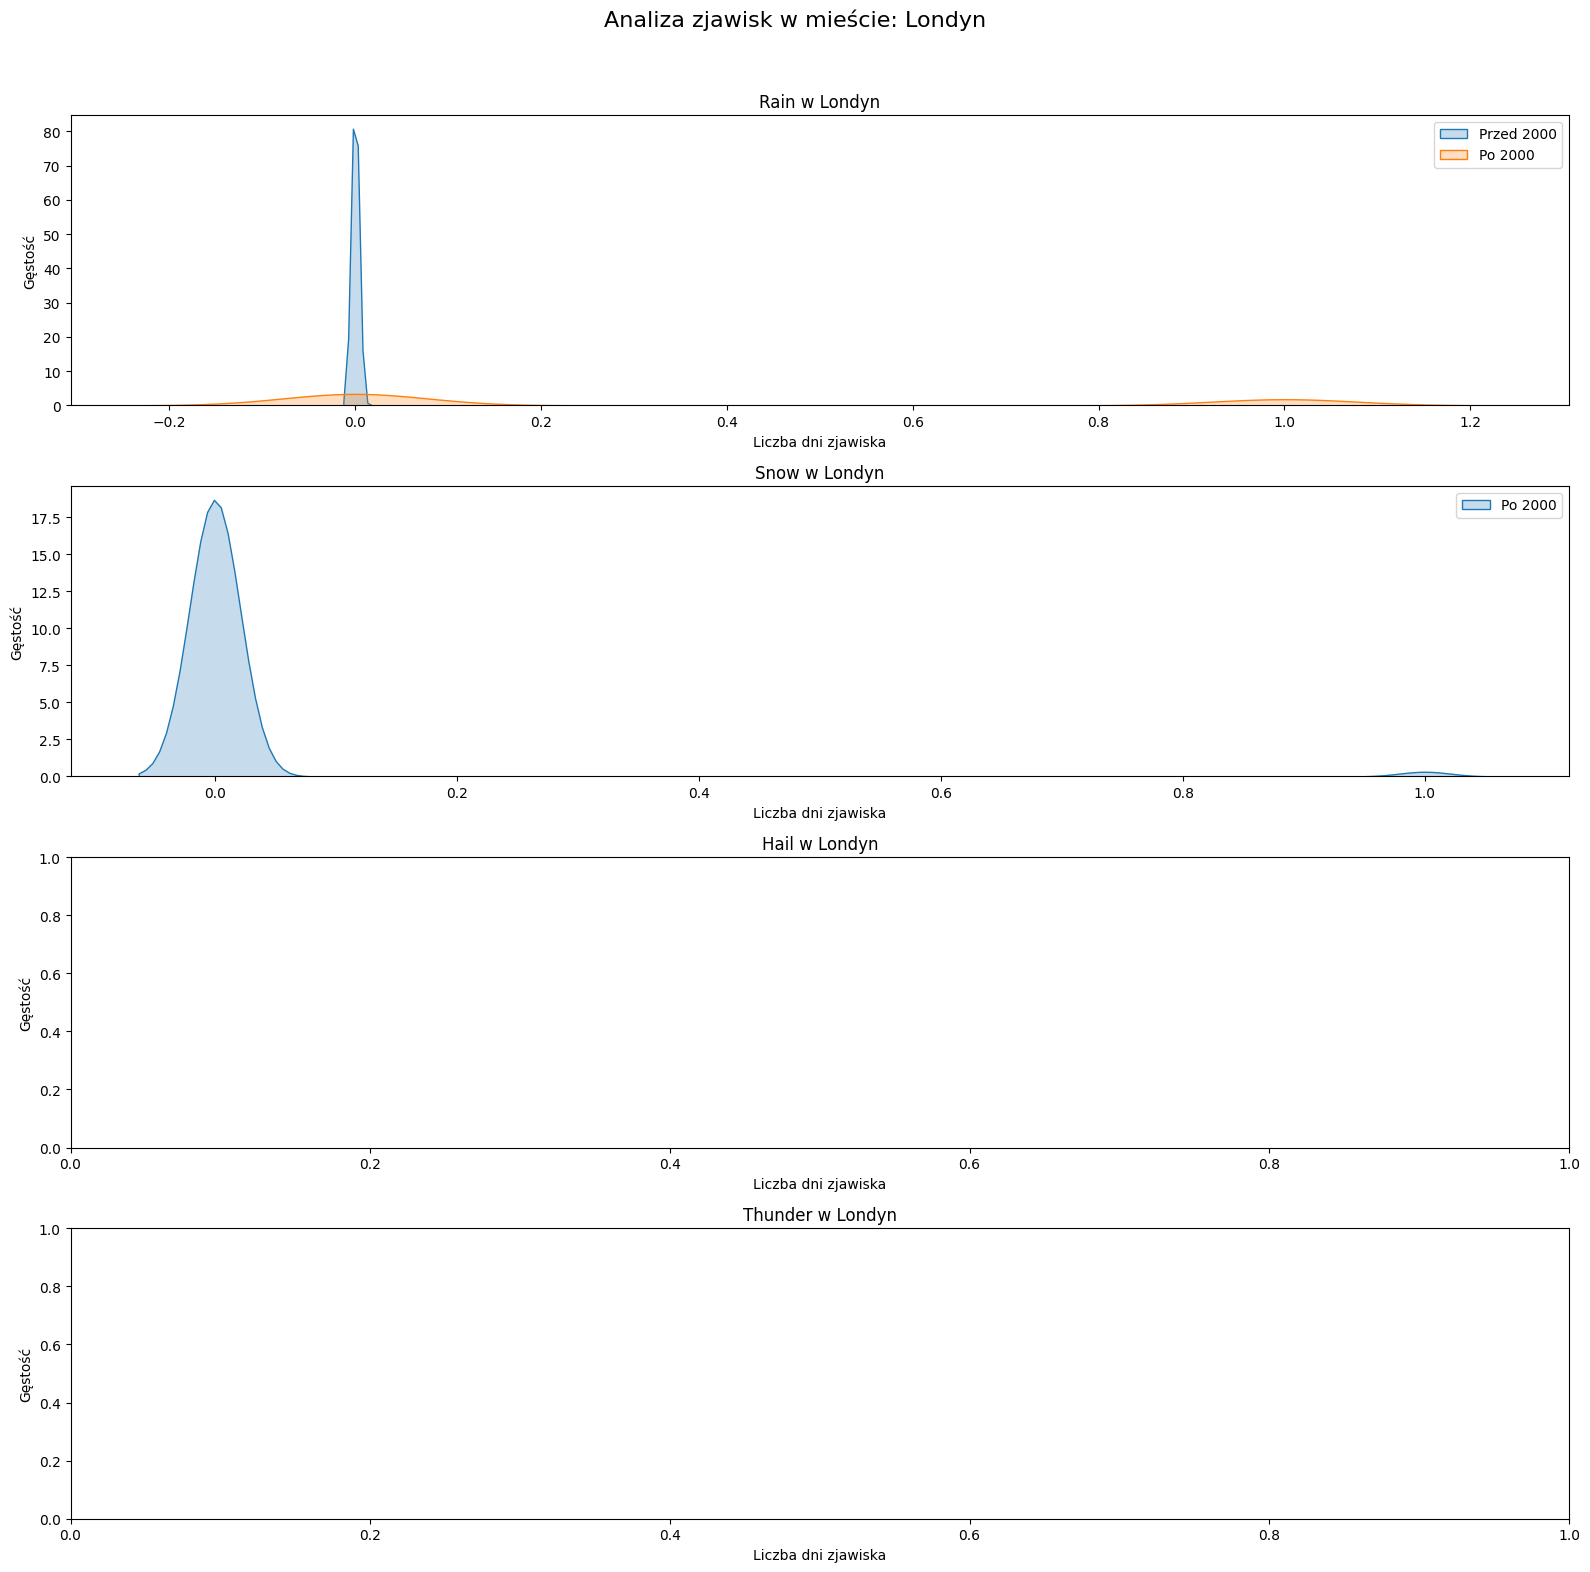

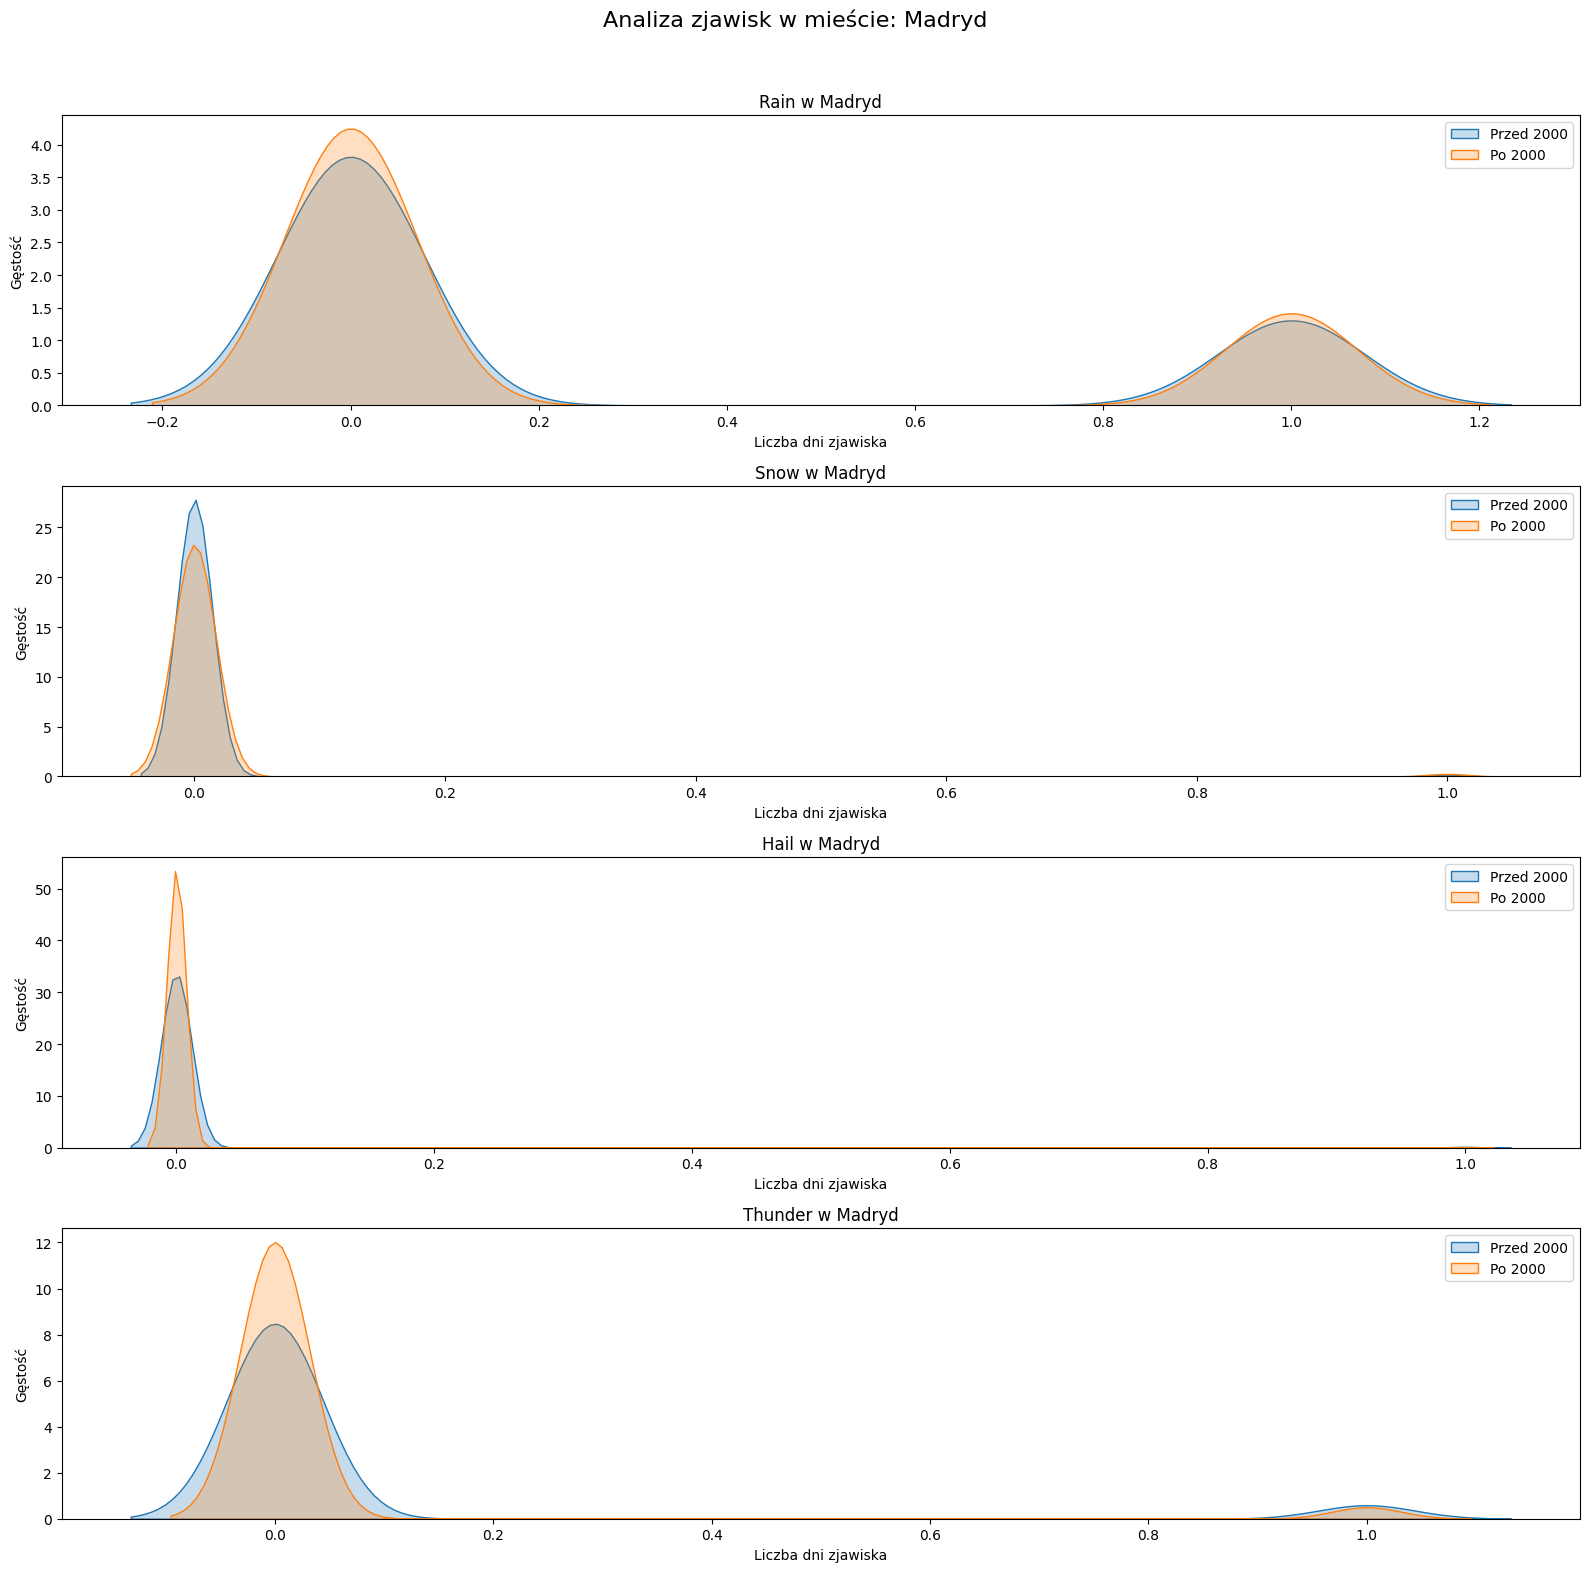

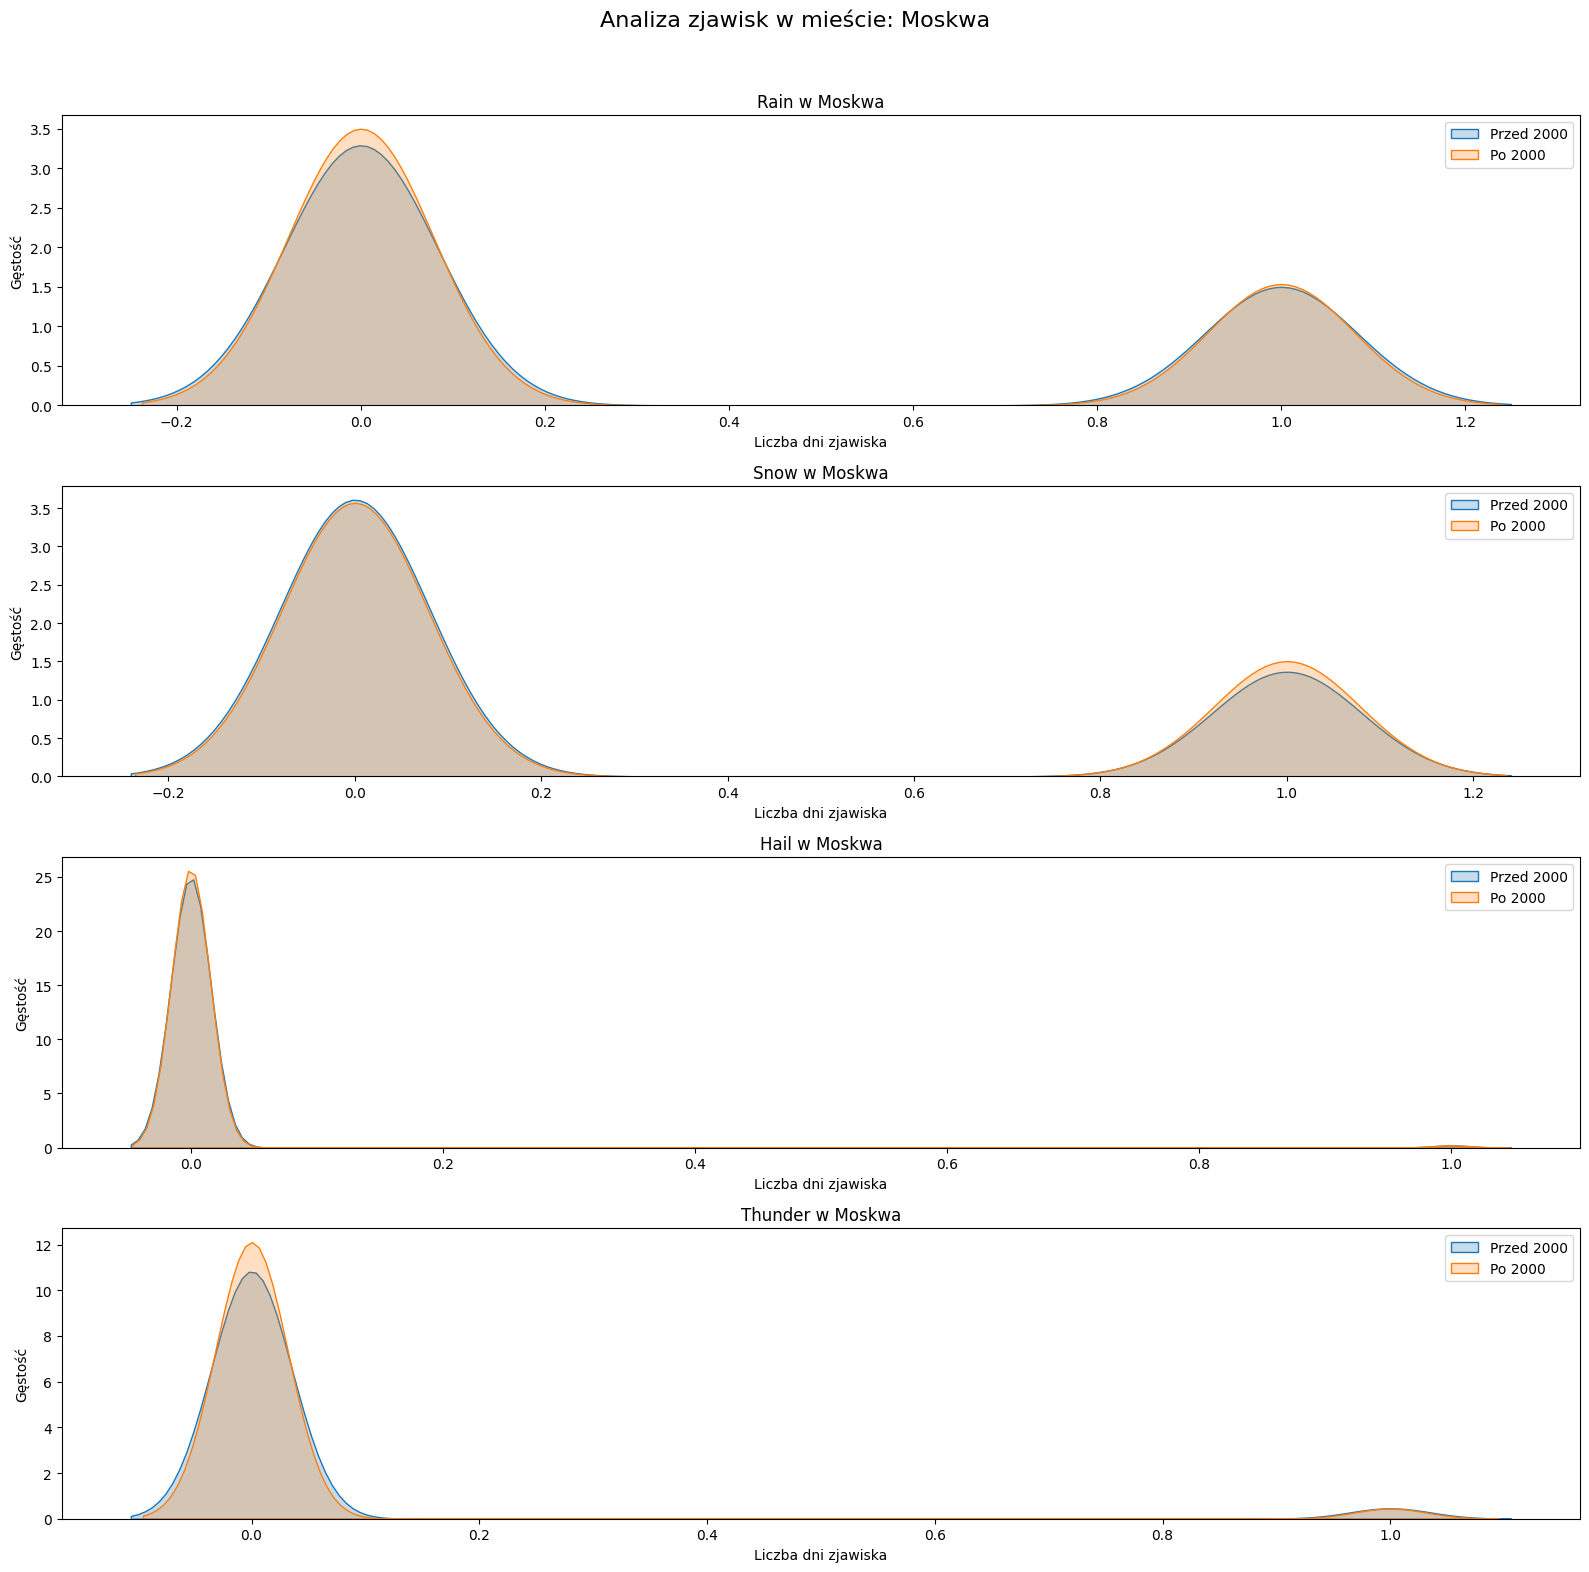

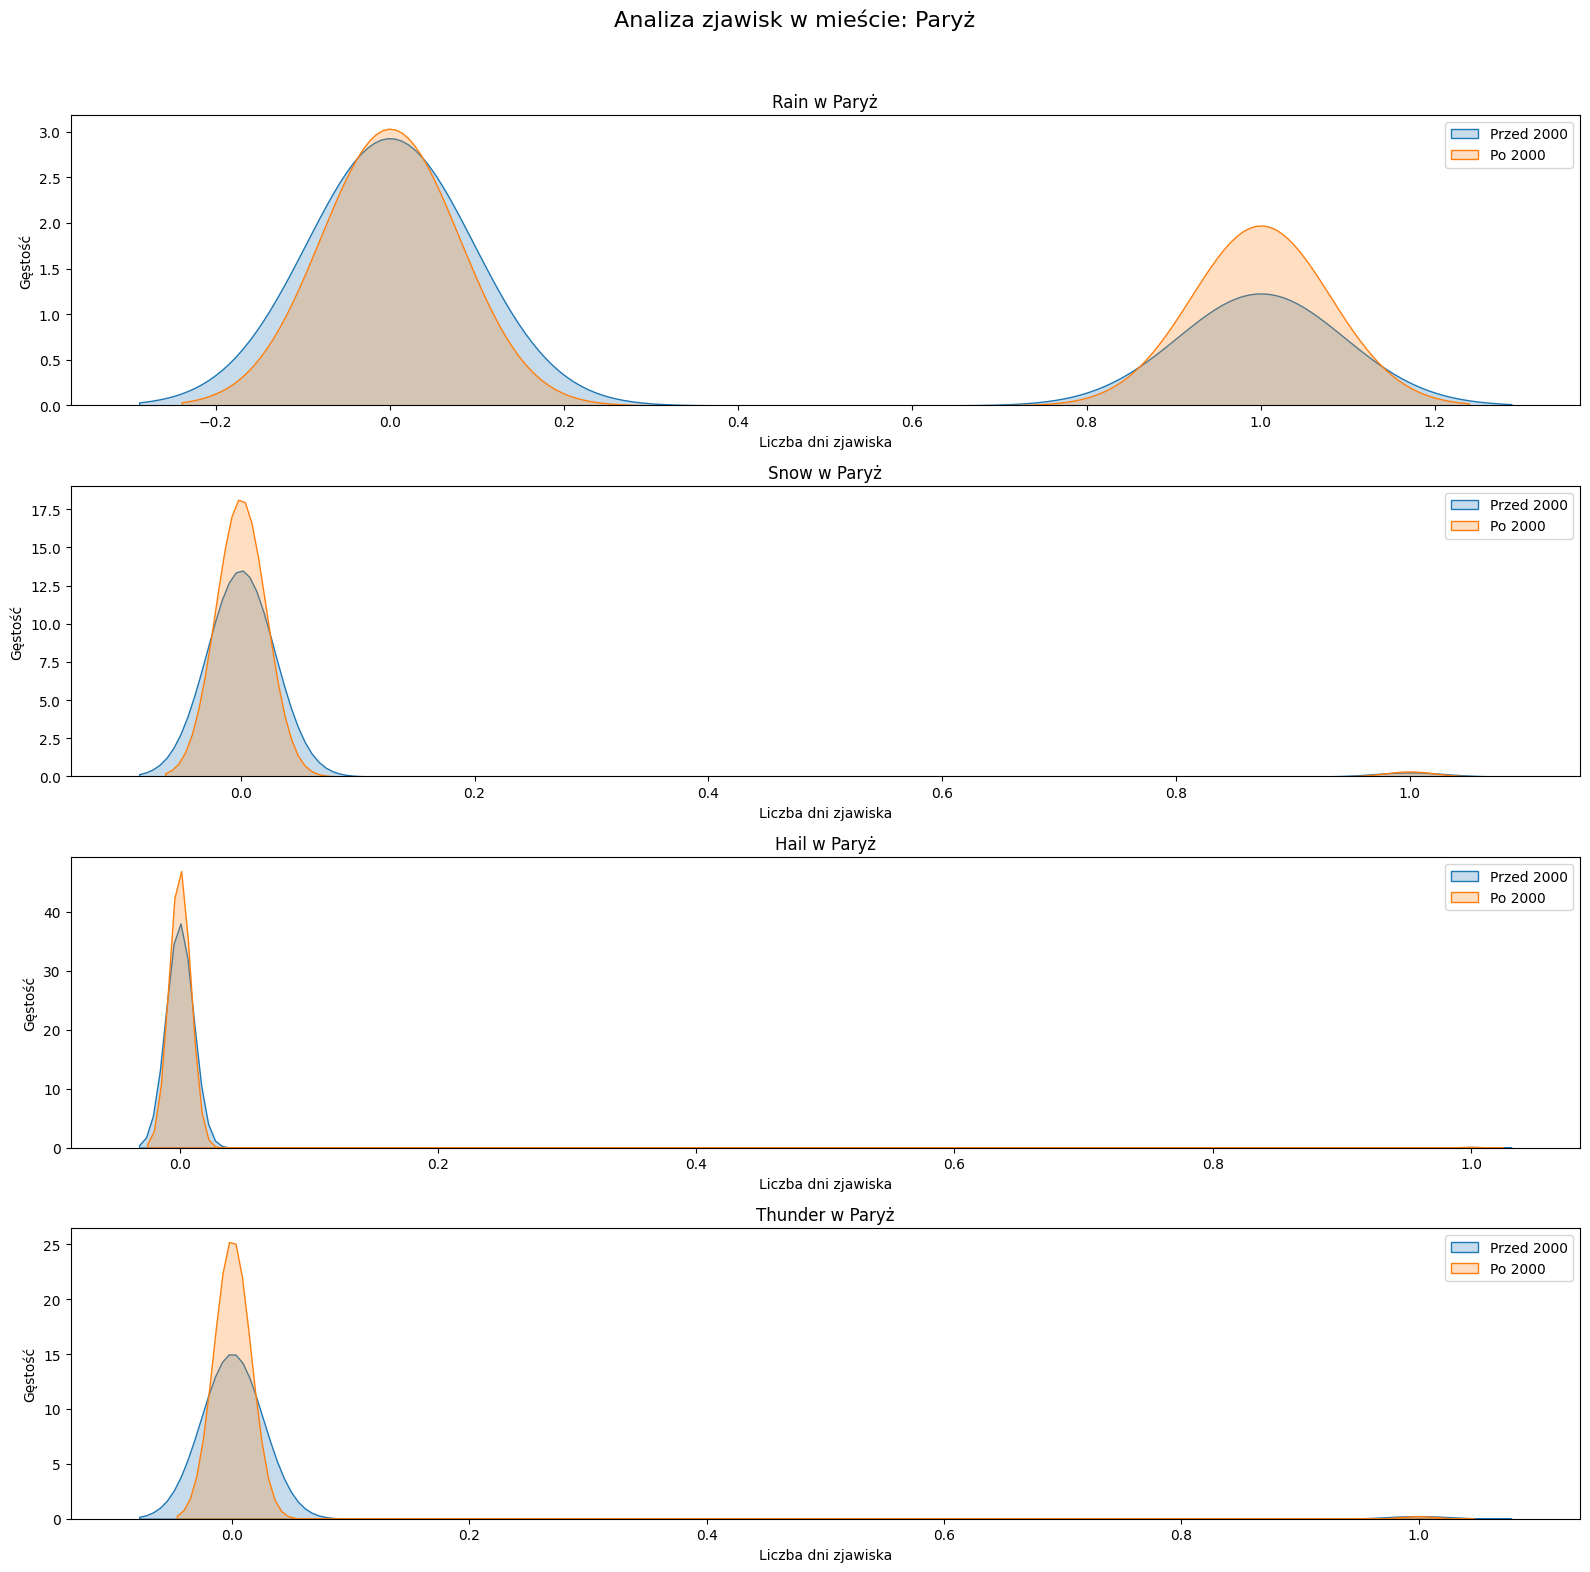

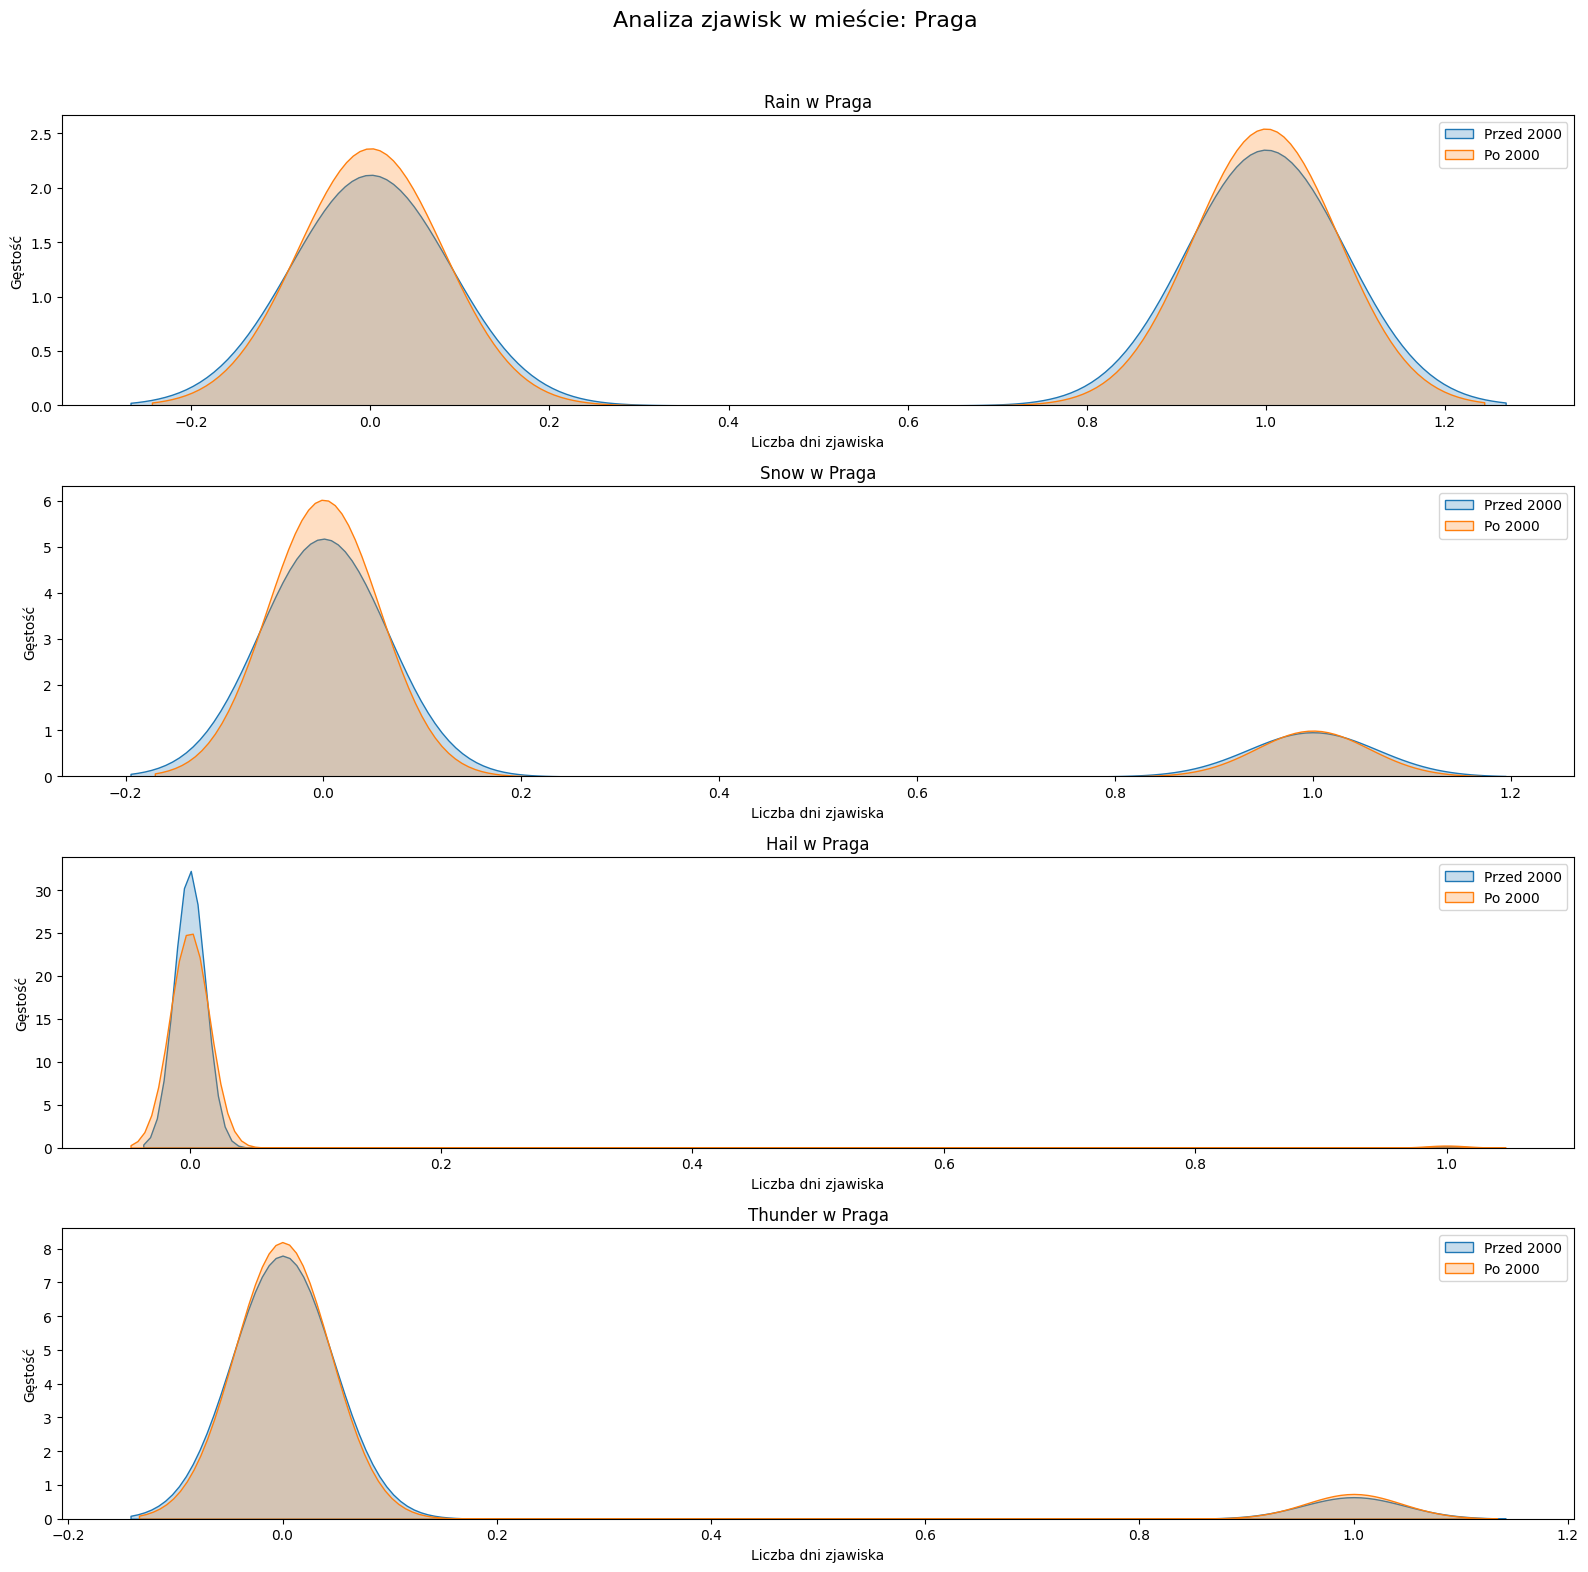

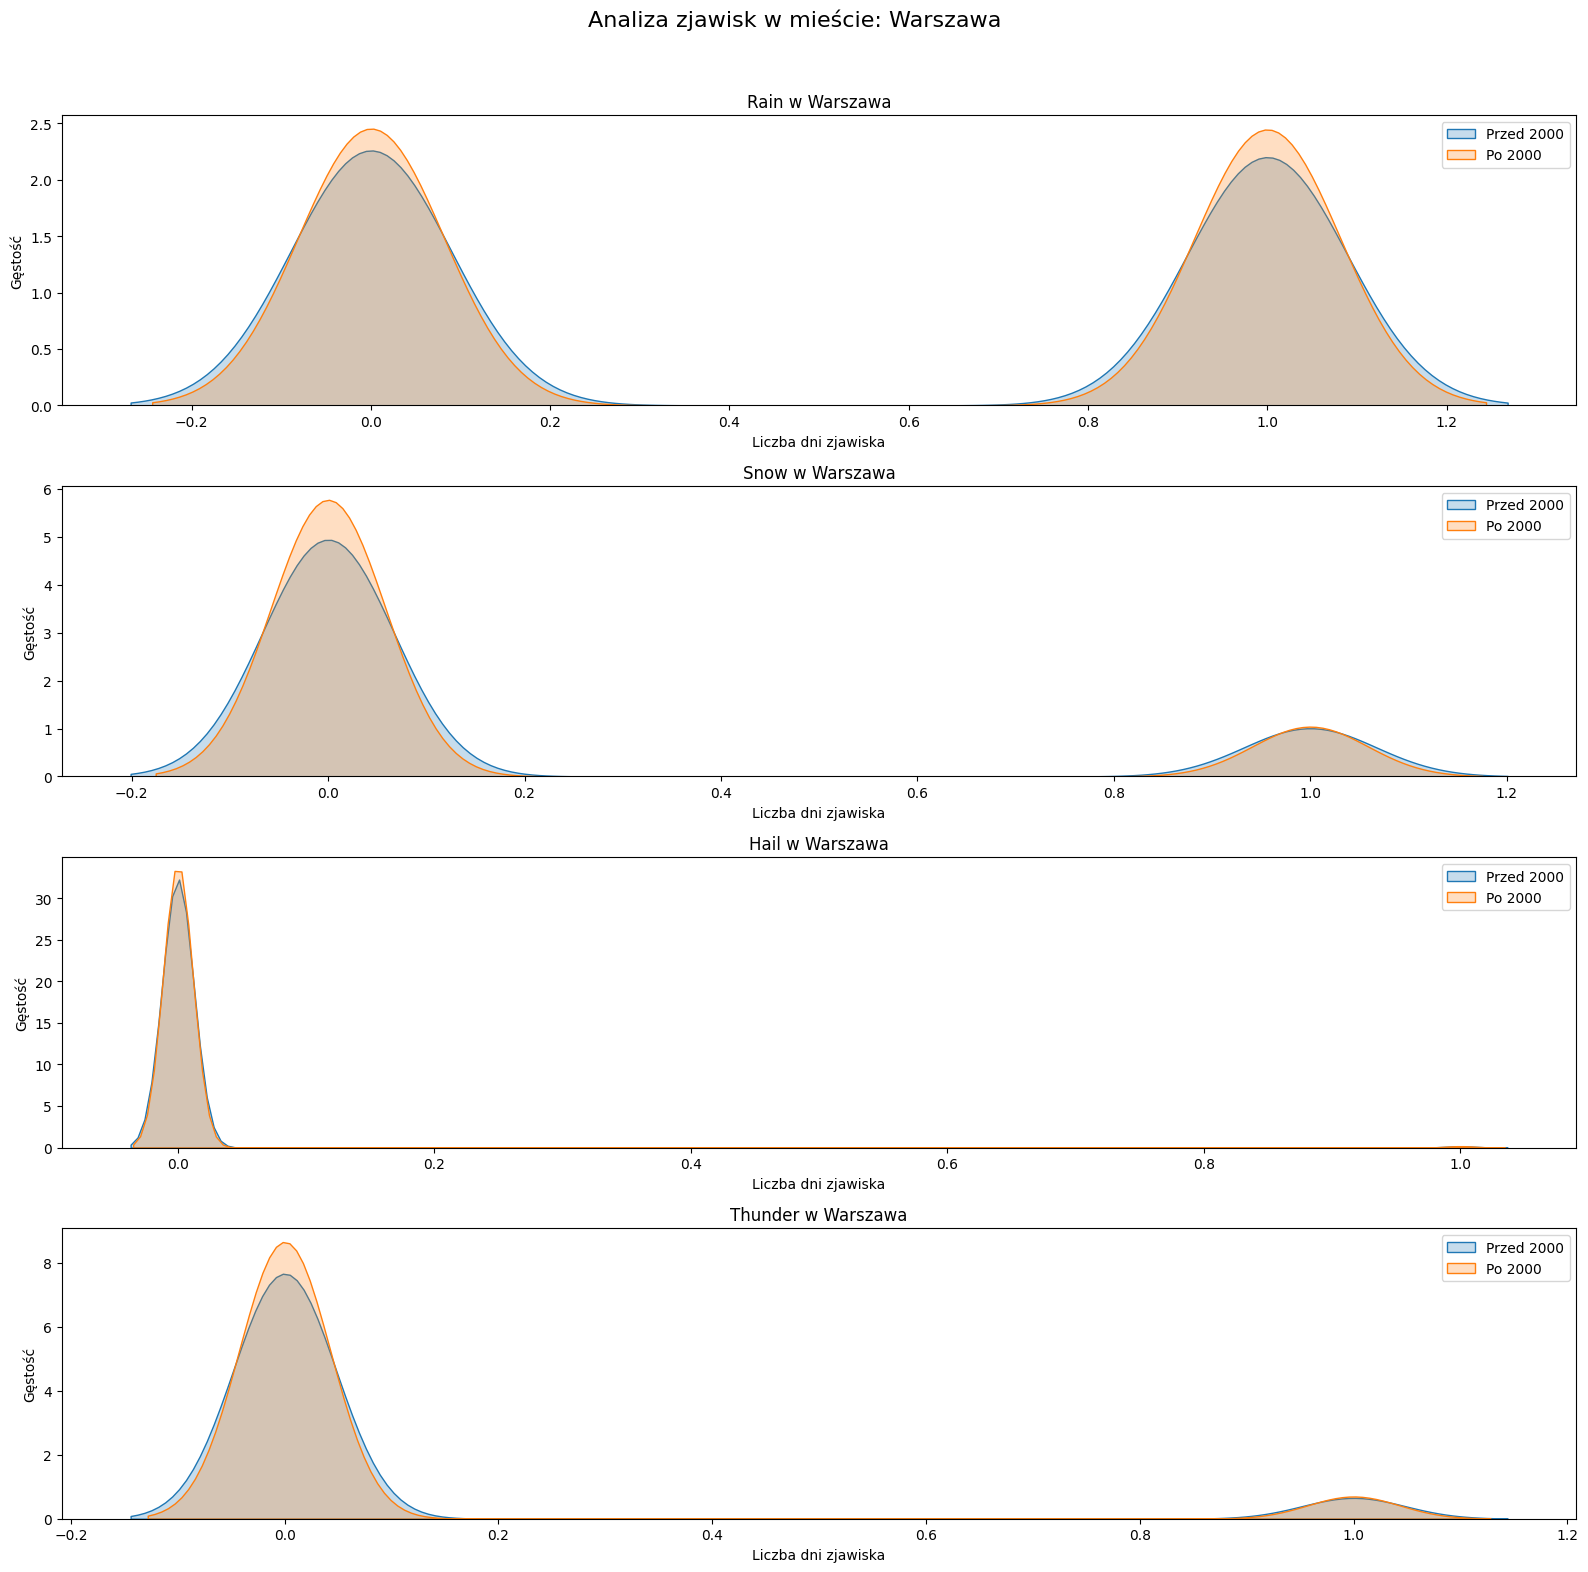

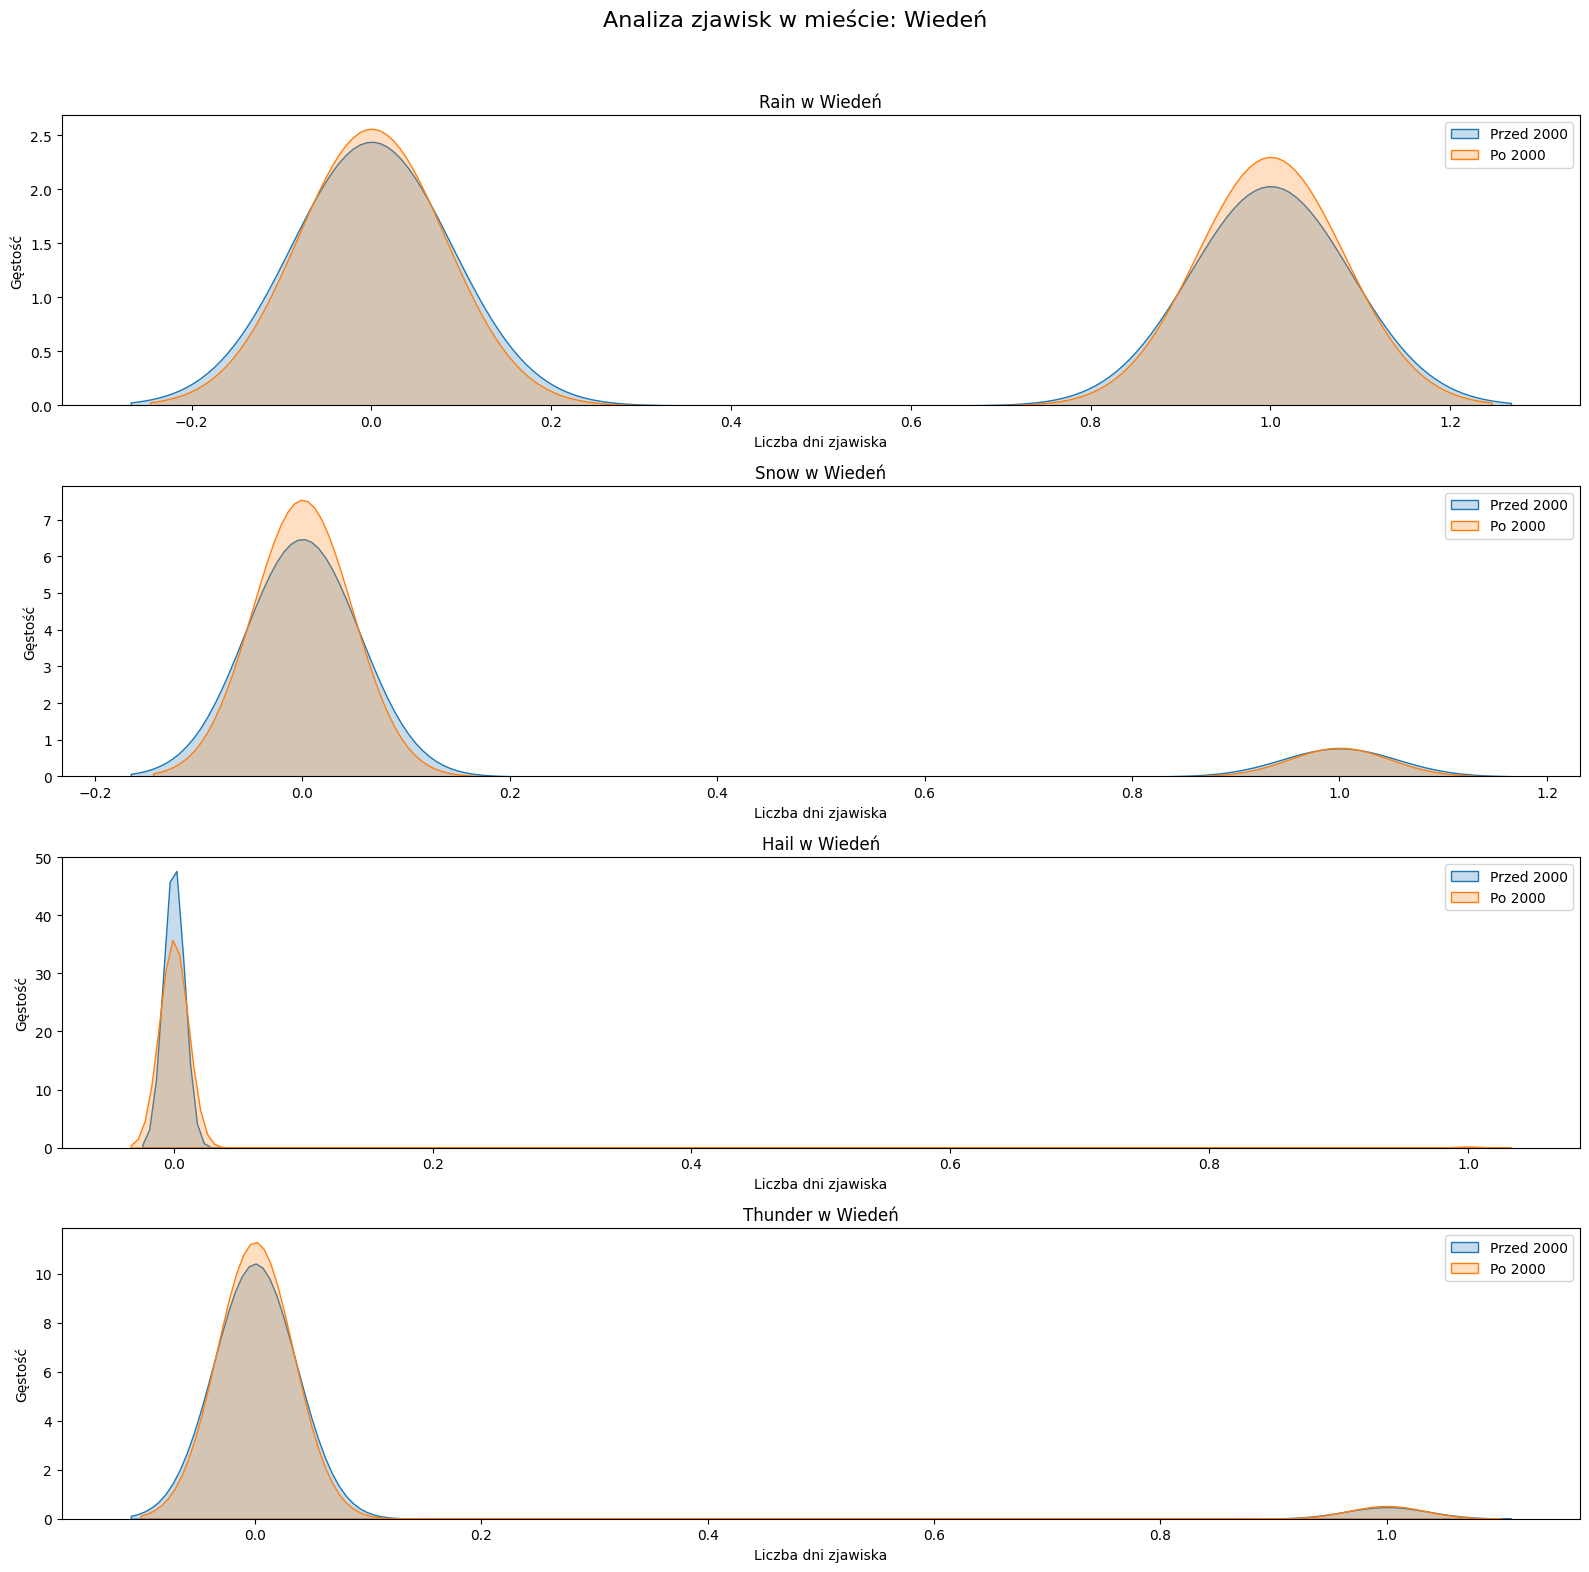

In [19]:
phenomena = ['Rain', 'Snow', 'Hail', 'Thunder']
split_year = 2000
city_list = list(cities.keys())

results = analyze_phenomena_cities(cities, city_list, phenomena, split_year)

In [20]:
def results_to_dataframe(results):
    rows = []
    for city, city_results in results.items():
        for phenomenon, stats in city_results.items():
            row = {'City': city, 'Phenomenon': phenomenon}
            row.update(stats)
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [21]:
df_results = results_to_dataframe(results)
display(df_results) 

City Phenomenon  Shapiro_p_before  Shapiro_p_after       Levene_p  \
0       Ateny       Rain               NaN              NaN            NaN   
1       Ateny       Snow               NaN              NaN            NaN   
2       Ateny       Hail               NaN              NaN            NaN   
3       Ateny    Thunder               NaN              NaN            NaN   
4      Berlin       Rain      2.695733e-62     5.507206e-48   2.236344e-07   
5      Berlin       Snow      1.665489e-71     6.284880e-58   4.094982e-03   
6      Berlin       Hail      3.708736e-79     2.581227e-65   1.366008e-07   
7      Berlin    Thunder      1.684187e-74     1.919951e-60   5.206889e-03   
8    Bruksela       Rain               NaN              NaN   3.036256e-01   
9    Bruksela       Snow               NaN              NaN   2.072901e-01   
10   Bruksela       Hail               NaN              NaN   7.735213e-01   
11   Bruksela    Thunder               NaN              NaN   6.457070e-02   
12  Budapeszt       Rain               NaN              NaN   1.115748e-02   
13  Budapeszt       Snow               NaN              NaN   2.909863e-02   
14  Budapeszt       Hail               NaN              NaN   5.369767e-01   
15  Budapeszt    Thunder               NaN              NaN   3.589183e-01   
16    Lisbona       Rain               NaN              NaN  1.191697e-102   
17    Lisbona       Snow               NaN              NaN   7.807097e-01   
18    Lisbona       Hail               NaN              NaN   3.690982e-01   
19    Lisbona    Thunder               NaN              NaN   4.379817e-09   
20     Londyn       Rain      4.359980e-90              NaN   0.000000e+00   
21     Londyn       Snow               NaN              NaN   9.084872e-17   
22     Londyn       Hail               NaN              NaN            NaN   
23     Londyn    Thunder               NaN              NaN            NaN   
24     Madryd       Rain               NaN              NaN   4.886720e-01   
25     Madryd       Snow               NaN              NaN   5.520483e-03   
26     Madryd       Hail               NaN              NaN   1.267305e-02   
27     Madryd    Thunder               NaN              NaN   2.653561e-11   
28     Moskwa       Rain               NaN              NaN   3.284914e-01   
29     Moskwa       Snow               NaN              NaN   8.484126e-03   
30     Moskwa       Hail               NaN              NaN   9.223099e-01   
31     Moskwa    Thunder               NaN              NaN   1.520077e-01   
32      Paryż       Rain      8.013242e-61              NaN   4.446836e-19   
33      Paryż       Snow      7.142798e-75              NaN   6.025870e-01   
34      Paryż       Hail      6.409612e-77              NaN   8.768011e-01   
35      Paryż    Thunder      2.966538e-75              NaN   5.298385e-03   
36      Praga       Rain               NaN              NaN   3.929856e-01   
37      Praga       Snow               NaN              NaN   1.644207e-02   
38      Praga       Hail               NaN              NaN   2.036437e-03   
39      Praga    Thunder               NaN              NaN   1.712479e-01   
40   Warszawa       Rain               NaN              NaN   4.958571e-01   
41   Warszawa       Snow               NaN              NaN   8.473151e-03   
42   Warszawa       Hail               NaN              NaN   7.494245e-01   
43   Warszawa    Thunder               NaN              NaN   3.887326e-01   
44     Wiedeń       Rain               NaN              NaN   2.800904e-02   
45     Wiedeń       Snow               NaN              NaN   2.225501e-02   
46     Wiedeń       Hail               NaN              NaN   1.544499e-02   
47     Wiedeń    Thunder               NaN              NaN   8.997882e-01   

    MannWhitney_p  Std_before  Std_after  CV_before   CV_after  Mean_before  \
0             NaN         NaN   0.420346        NaN   1.833985          NaN   
1             NaN         Na